In [1]:
import pandas as pd
import numpy as np 
import wrangle
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# import and prepare the data
- data acquired from local csv file, which was downloaded from kaggle
- added rank, tier, and is successful columns to the csv file
- dropped the wallpaper, birthday, catchphrase, flooring, furniture, filename, and unique entry id
-got rid of spaces  in the column names
- manually filled in the null data from the animal crossing webpage
    -included 22 characters that were missing from the original csv file, but were on the tier list

In [2]:
# import the data from local csv
df = wrangle.get_acnh_data()

In [3]:
df.head()

,Rank,Tier,Species,Gender,Personality,Hobby,Birthday,Catchphrase,Favorite Song,Style 1,Style 2,Color 1,Color 2,Wallpaper,Flooring,Furniture List,Filename,Unique Entry ID
Name,,,,,,,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,29-Sep,sulky,K.K. Bossa,Elegant,Cool,Light blue,Blue,blue delicate-blooms wall,modern wood flooring,2554;1081;3681;9766;1161;3615;1845;8394;3271;3...,squ17,ZZJJbE5zFrcDXfLEF
Raymond,2,1,Cat,Male,Smug,Nature,1-Oct,crisp,K.K. Cruisin',Elegant,Cool,Black,Gray,office wall,monochromatic tile flooring,840;4116;1750;3590;1232;832;3560;839;3784;1744...,cat23,2nbzgWsuDBSN2LeEj
Shino,3,1,Deer,Female,Peppy,Education,31-Oct,okaaay,K.K. Folk,Elegant,Gorgeous,Red,Black,NaN,NaN,NaN,NaN,NaN
Sasha,4,1,Rabbit,Male,Lazy,Fashion,19-May,hoppity,K.K Robot Synth,Simple,Cute,Blue,White,NaN,NaN,NaN,NaN,NaN
Zucker,5,1,Octopus,Male,Lazy,Nature,8-Mar,bloop,Spring Blossoms,Simple,Cute,Blue,Yellow,chain-link fence,backyard lawn,4042;4412;7526;4077;4077;3064;4077;3946;3617;3...,ocp02,2F5tipHqgmWvWXTLC


In [4]:
# prepare the data using wrangle file 
df = wrangle.prep_acnh_data(df)

In [5]:
df.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1
Raymond,2,1,Cat,Male,Smug,Nature,K.K. Cruisin',Elegant,Cool,Black,Gray,1
Shino,3,1,Deer,Female,Peppy,Education,K.K. Folk,Elegant,Gorgeous,Red,Black,1
Sasha,4,1,Rabbit,Male,Lazy,Fashion,K.K Robot Synth,Simple,Cute,Blue,White,1
Zucker,5,1,Octopus,Male,Lazy,Nature,Spring Blossoms,Simple,Cute,Blue,Yellow,1


In [6]:
df.shape

(413, 12)

In [7]:
#ensure that the is successful worked properly
df.is_successful.value_counts()

0    343
1     70
Name: is_successful, dtype: int64

- testing function to put into wrangle file


def successful(tier):
    if tier == 1 or tier == 2 or tier == 3:
        return 1
    else:
        return 0
    

- applying function to df to ensure it works

df["successful"] = df["tier"].apply(lambda tier: successful(tier))

In [8]:
# success is defined as being in the top 3 tiers. these 3 tiers account for the top 17% of the characters
df.tier.value_counts()

6    163
5    120
4     60
3     30
2     25
1     15
Name: tier, dtype: int64

In [9]:
70 / 413

0.1694915254237288

In [10]:
def split_acnh_data(df):

    train_validate, test = train_test_split(df, test_size=.15, 
        random_state=123)

    train, validate = train_test_split(train_validate, test_size=.20, 
        random_state=17)
    return train, validate, test


In [11]:
train, validate, test = split_acnh_data(df)

In [12]:
train.shape, validate.shape, test.shape

((280, 12), (71, 12), (62, 12))

### some points to make before starting exploration

- Being in tier 1, 2, or 3 determines whether or not a character is successful
    - this corresponds with a rank between 1-70, with a rank higher than 70 being in a lower tier and thus unsuccessful
- i'm not seeing these as characters in a game, but rather products and attributes of the products

- I want to see what possible attributes could be influencing the popularity of these products and, hopefully, make recommendations on what attributes we can combine in the future to make products that are more likely to be popular. 

- I also want to test whether a new, unseen, character would be successful based on the combination of attributes that it is given

- Key point in this project is that i will not be using "cuteness" of a character as a factor, since "cuteness" is a matter of personal opinion so there is no real way to measure it. Plus some things are so ugly they can be cute. Additionally, there are some characters that can be considered cute that aren't successful and there are some characters that are not considered cute that do well. 

- another side factor to consider is that color_1 is typically the color of the characters clothes. 

- I am leaving in favorite song, since it will be playing in the character's house. If a song really annoys a person, they could be less apt to keep that character. 

# Exploration

### initial hypotheses: 
- the species, hobby, and color_1 play a large part on whether or not a character will be successful
- while favorite_song might play a roll, i don't know that it will be significant enough to determine whether a character will be successful
- the style of the character will also play a role, since this will be tied in with how they look


In [13]:
df.gender.value_counts()

Male      214
Female    199
Name: gender, dtype: int64

In [14]:
train.groupby('is_successful').gender.value_counts()


is_successful  gender
0              Male      121
               Female    112
1              Female     26
               Male       21
Name: gender, dtype: int64

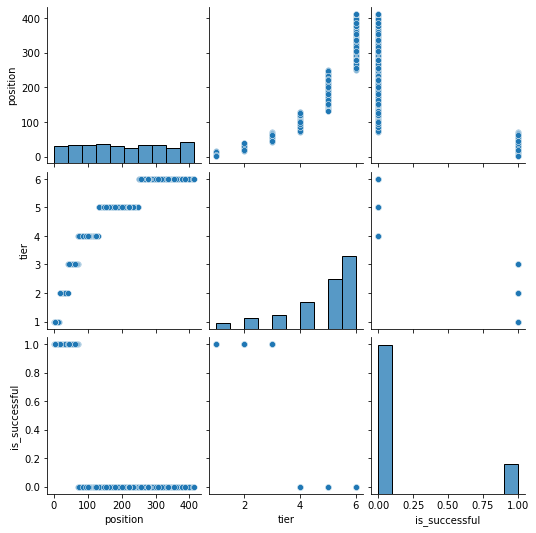

In [15]:
sns.pairplot(train)

In [16]:
train.dtypes

position          int64
tier              int64
species          object
gender           object
personality      object
hobby            object
favorite_song    object
style_1          object
style_2          object
color_1          object
color_2          object
is_successful     int64
dtype: object

In [17]:
train.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,Red,1
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,Green,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,Blue,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,Colorful,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,White,1


testing_rename = train.rename(columns={'rank':'position'})

testing_rename.head(1)

In [18]:
overall_mean= train.position.mean()

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

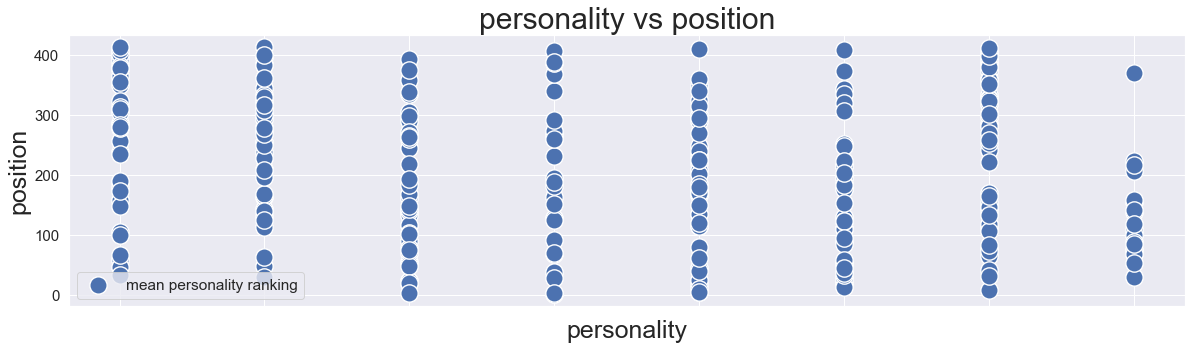

In [19]:
plt.figure(figsize=(20,5))
sns.set(font_scale = 1.4)
ax = sns.scatterplot(x='personality', y = 'position', data = train, label = 'mean personality ranking', s = 300)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("personality vs position", fontsize = 30)
plt.xlabel("personality",fontsize=25)
plt.ylabel("position", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


<AxesSubplot:ylabel='is_successful,gender'>

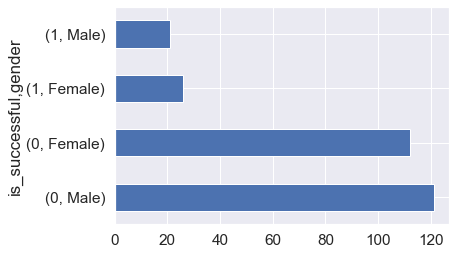

In [20]:
train.groupby('is_successful').gender.value_counts().plot.barh()

<AxesSubplot:xlabel='personality', ylabel='position'>

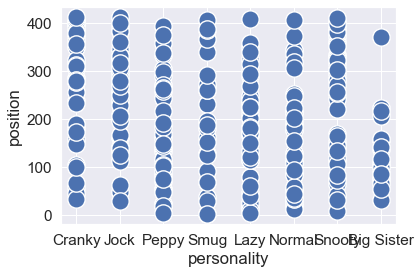

In [21]:
sns.scatterplot(x='personality', y = 'position' , data = train, s = 300)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

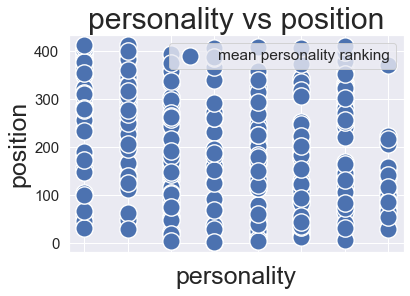

In [22]:
ax = sns.scatterplot(x='personality', y = 'position', data = train, label = 'mean personality ranking', s = 300)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("personality vs position", fontsize = 30)
plt.xlabel("personality",fontsize=25)
plt.ylabel("position", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


In [23]:
species_ranking = train.groupby('species').mean()['position'].to_frame().reset_index().sort_values('position')

In [24]:
species_ranking

,species,position
25,Octopus,26.33
34,Wolf,55.83
5,Cat,75.06
9,Deer,95.50
32,Squirrel,151.31
21,Koala,155.00
17,Hamster,158.60
10,Dog,161.08
29,Rabbit,170.12
26,Ostrich,182.88


<AxesSubplot:xlabel='species', ylabel='position'>

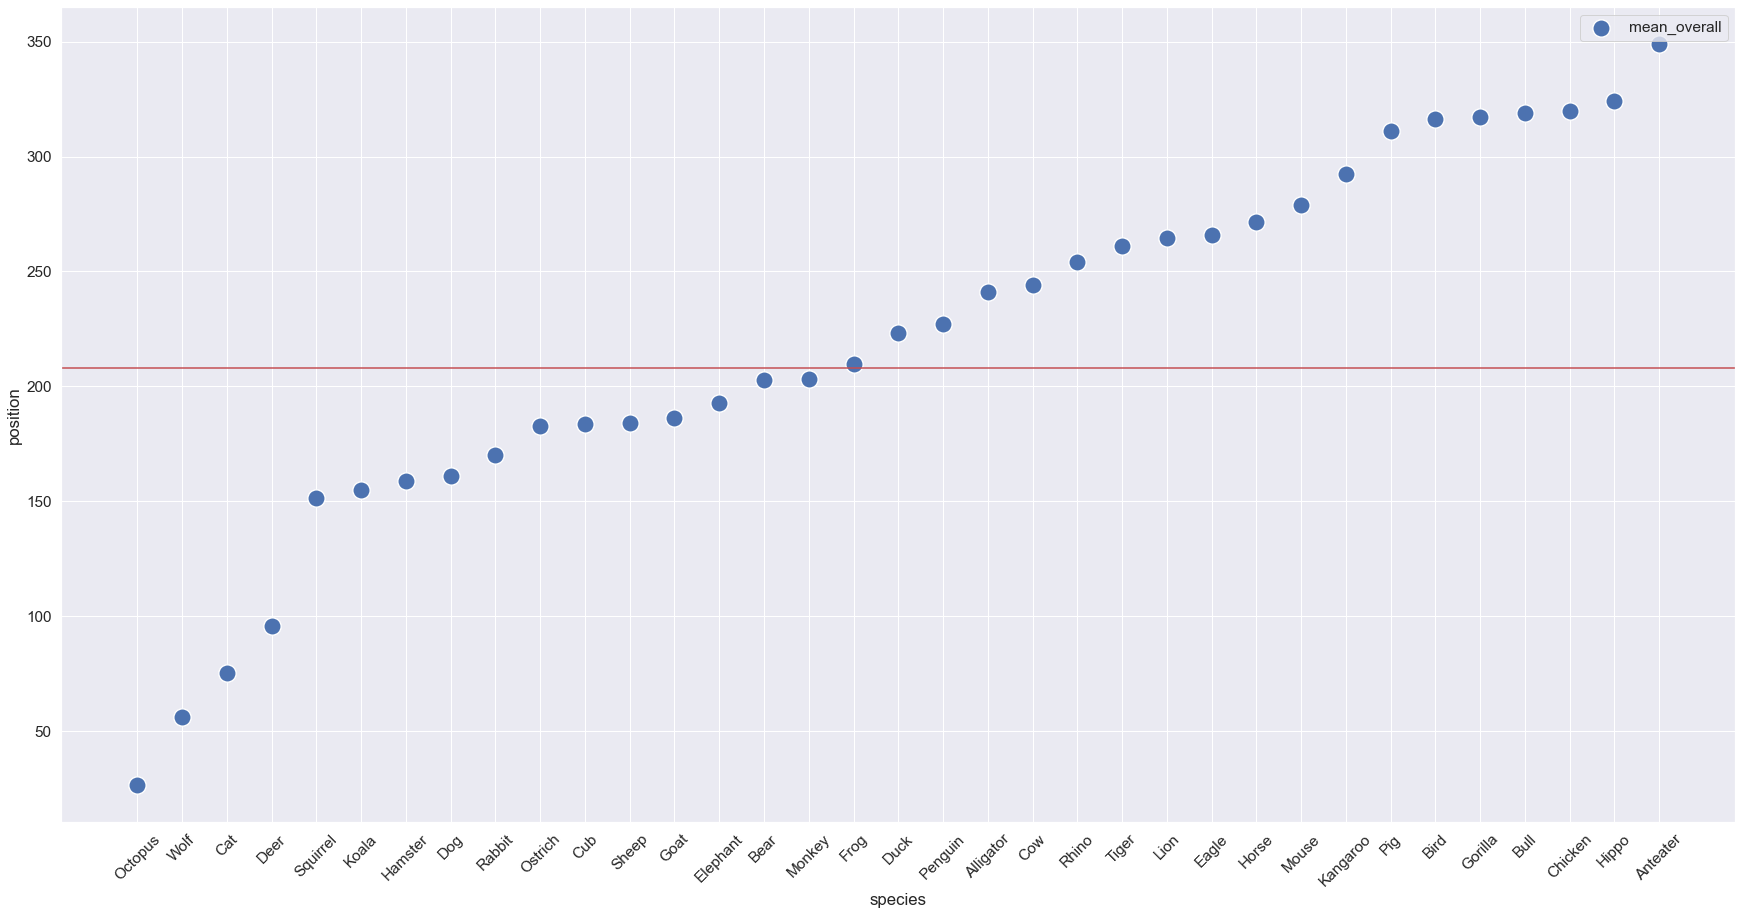

In [25]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='species', y="position", data=species_ranking,label='mean_overall', s=300)

In [26]:
personality_ranking = train.groupby('personality').mean()['position'].to_frame().reset_index().sort_values('position')

In [27]:
personality_ranking

,personality,position
0,Big Sister,133.17
4,Normal,163.49
5,Peppy,171.49
3,Lazy,182.56
6,Smug,193.00
7,Snooty,247.09
2,Jock,247.71
1,Cranky,271.10


<AxesSubplot:xlabel='personality', ylabel='position'>

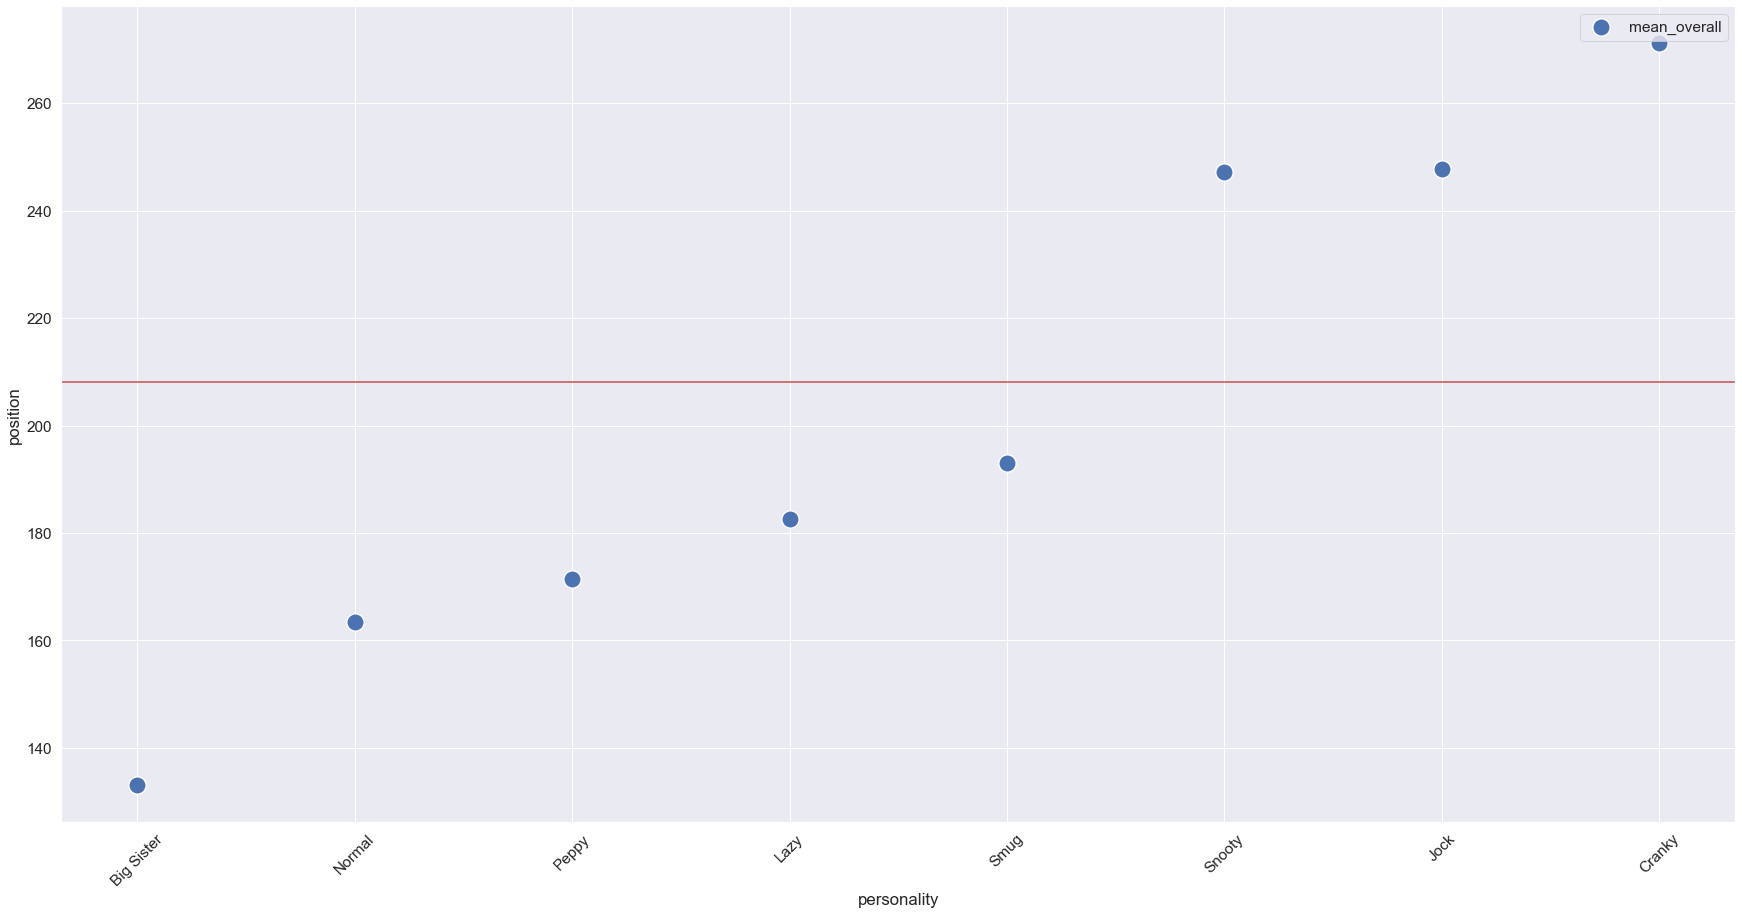

In [28]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='personality', y="position", data=personality_ranking,label='mean_overall', s=300)

In [29]:
hobby_ranking = train.groupby('hobby').mean()['position'].to_frame().reset_index().sort_values('position')

In [30]:
hobby_ranking

,hobby,position
5,Play,178.88
4,Nature,186.52
3,Music,200.40
0,Education,202.92
1,Fashion,221.91
2,Fitness,261.17


In [31]:
def trait_means(train):
    for trait in train.columns:
       trait_ranking= train.groupby(trait).mean()['position'].to_frame().reset_index().sort_values('position')

In [32]:
def trait_means(train):
    results = []

    for col in train.drop(columns = 'position').columns:
        col= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        results.append(col)
    return results


In [33]:
trait_means(train)[3]

,personality,position
0,Big Sister,133.17
4,Normal,163.49
5,Peppy,171.49
3,Lazy,182.56
6,Smug,193.00
7,Snooty,247.09
2,Jock,247.71
1,Cranky,271.10


In [34]:
len(trait_means(train))

11

In [35]:
lists = trait_means(train)

In [36]:
def trait_means_dicts(train):
    df_dict = {}

    for col in train.drop(columns = 'position').columns:
        df= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        df_dict[col] = df
    return df_dict

In [37]:
trait_means_dicts(train)

{'tier':    tier             position
 0     1                 6.56
 1     2                27.41
 2     3                55.81
 3     4               102.90
 4     5               185.56
 5     6               332.38,
 'species':       species             position
 25    Octopus                26.33
 34       Wolf                55.83
 5         Cat                75.06
 9        Deer                95.50
 32   Squirrel               151.31
 21      Koala               155.00
 17    Hamster               158.60
 10        Dog               161.08
 29     Rabbit               170.12
 26    Ostrich               182.88
 8         Cub               183.60
 31      Sheep               183.82
 15       Goat               186.00
 13   Elephant               192.67
 2        Bear               202.71
 23     Monkey               203.33
 14       Frog               209.64
 11       Duck               223.36
 27    Penguin               227.10
 0   Alligator               241.00
 7         Cow

In [38]:
trait_means_dicts(train)['style_1']

,style_1,position
2,Cute,172.94
5,Simple,187.81
3,Elegant,194.85
4,Gorgeous,235.65
1,Cool,238.26
0,Active,252.09


In [39]:
list(trait_means_dicts(train))

['tier',
 'species',
 'gender',
 'personality',
 'hobby',
 'favorite_song',
 'style_1',
 'style_2',
 'color_1',
 'color_2',
 'is_successful']

<AxesSubplot:xlabel='species', ylabel='position'>

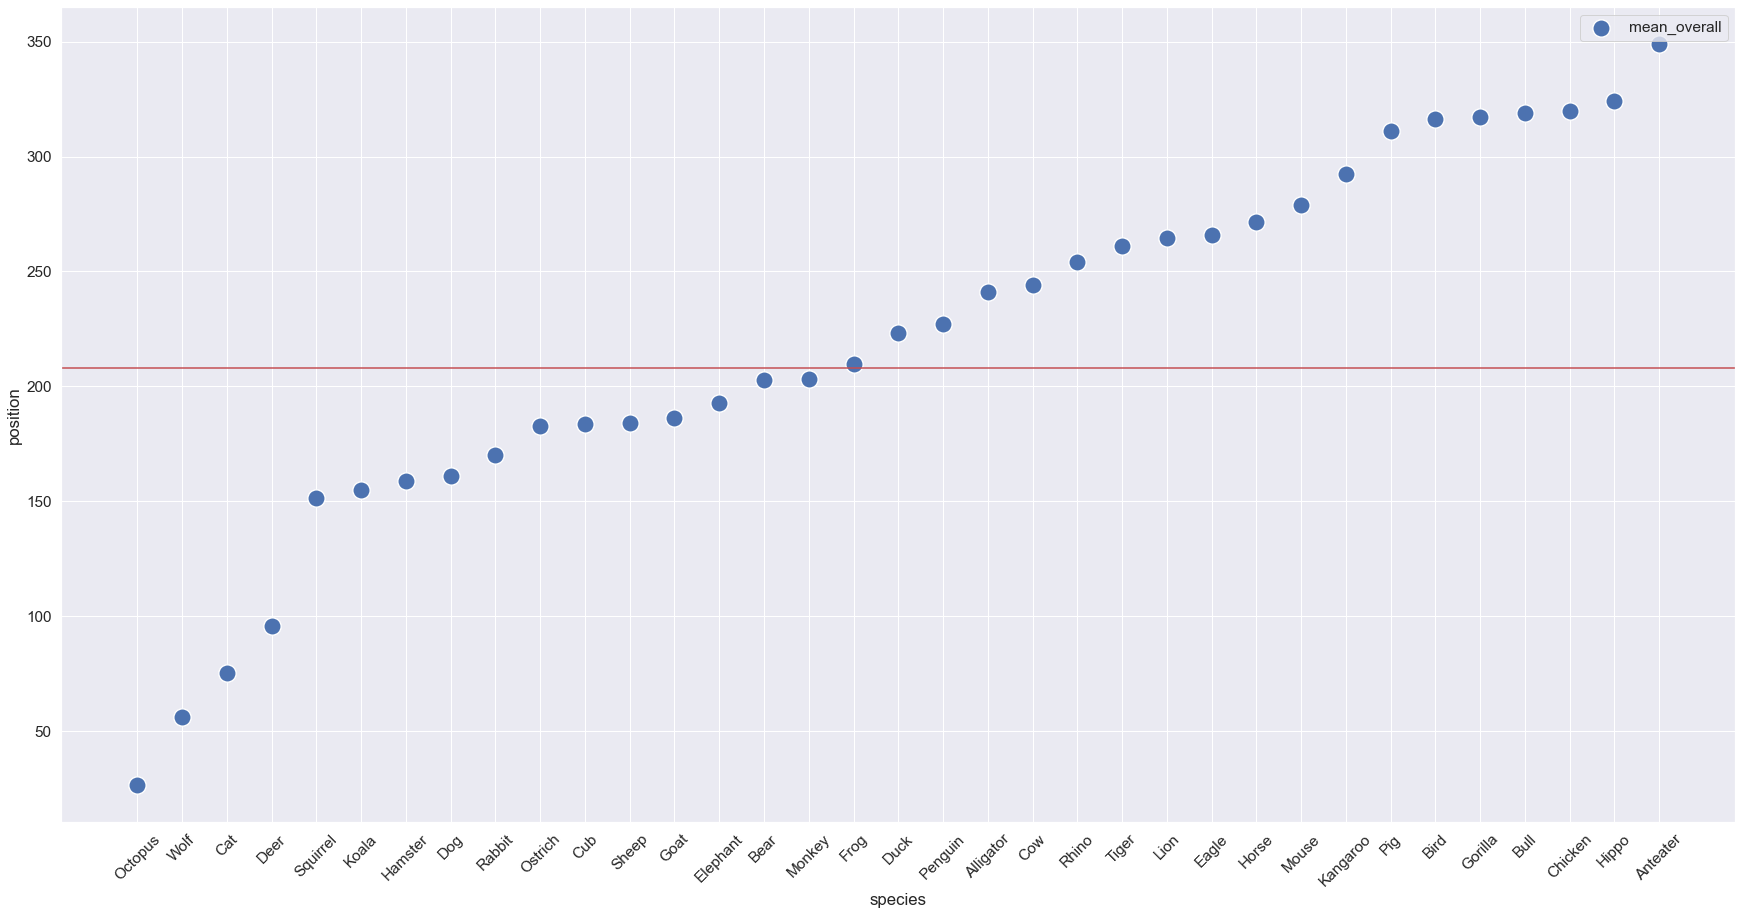

In [40]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x= 'species', y="position", data=trait_means_dicts(train)['species'],label='mean_overall', s=300)

<AxesSubplot:xlabel='gender', ylabel='position'>

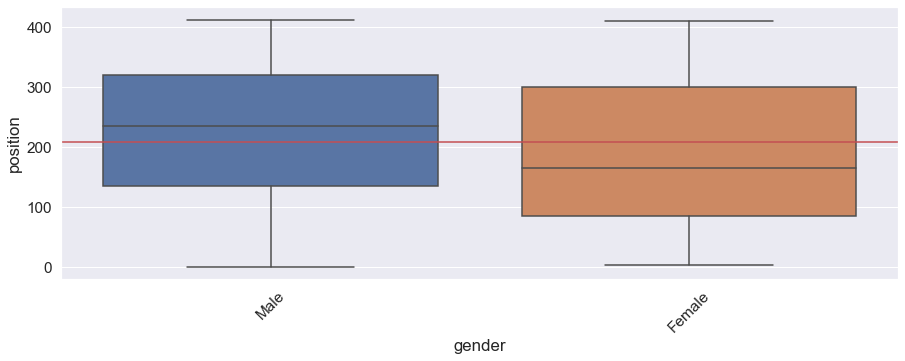

In [41]:
plt.figure(figsize=(15,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='gender', y="position", data=train)

In [42]:
def column_scatter_plots():
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        sns.scatterplot(x=col, y='position', data=trait_means_dicts(train)[col],label='mean_overall', s=300)

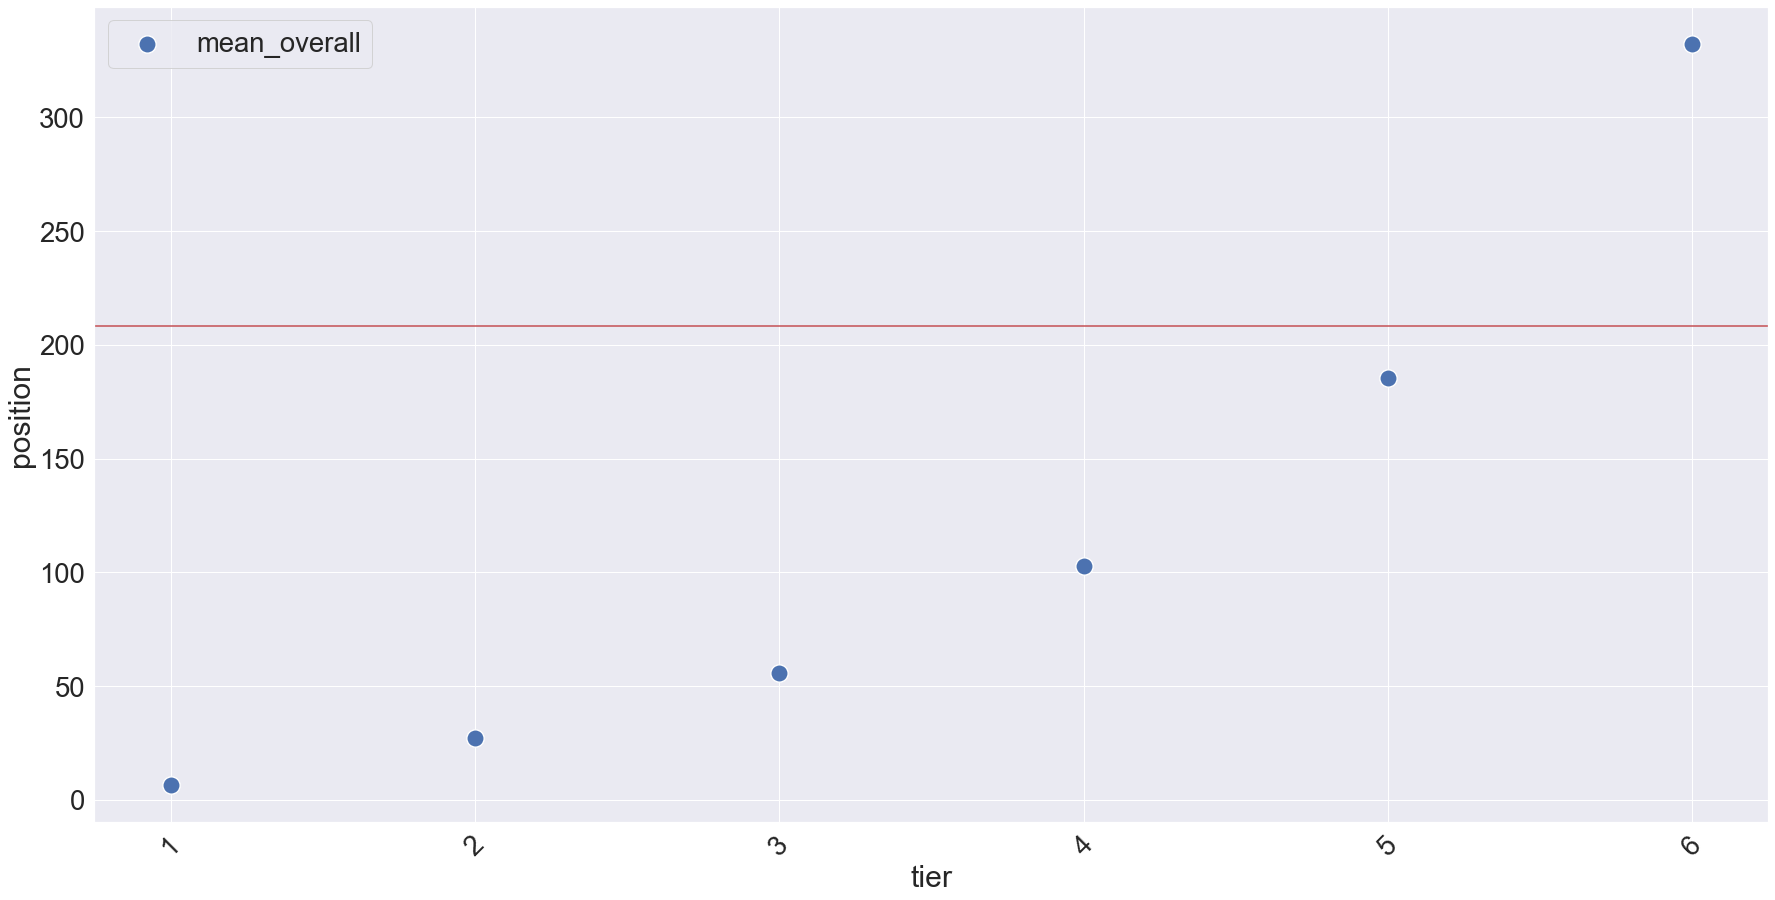

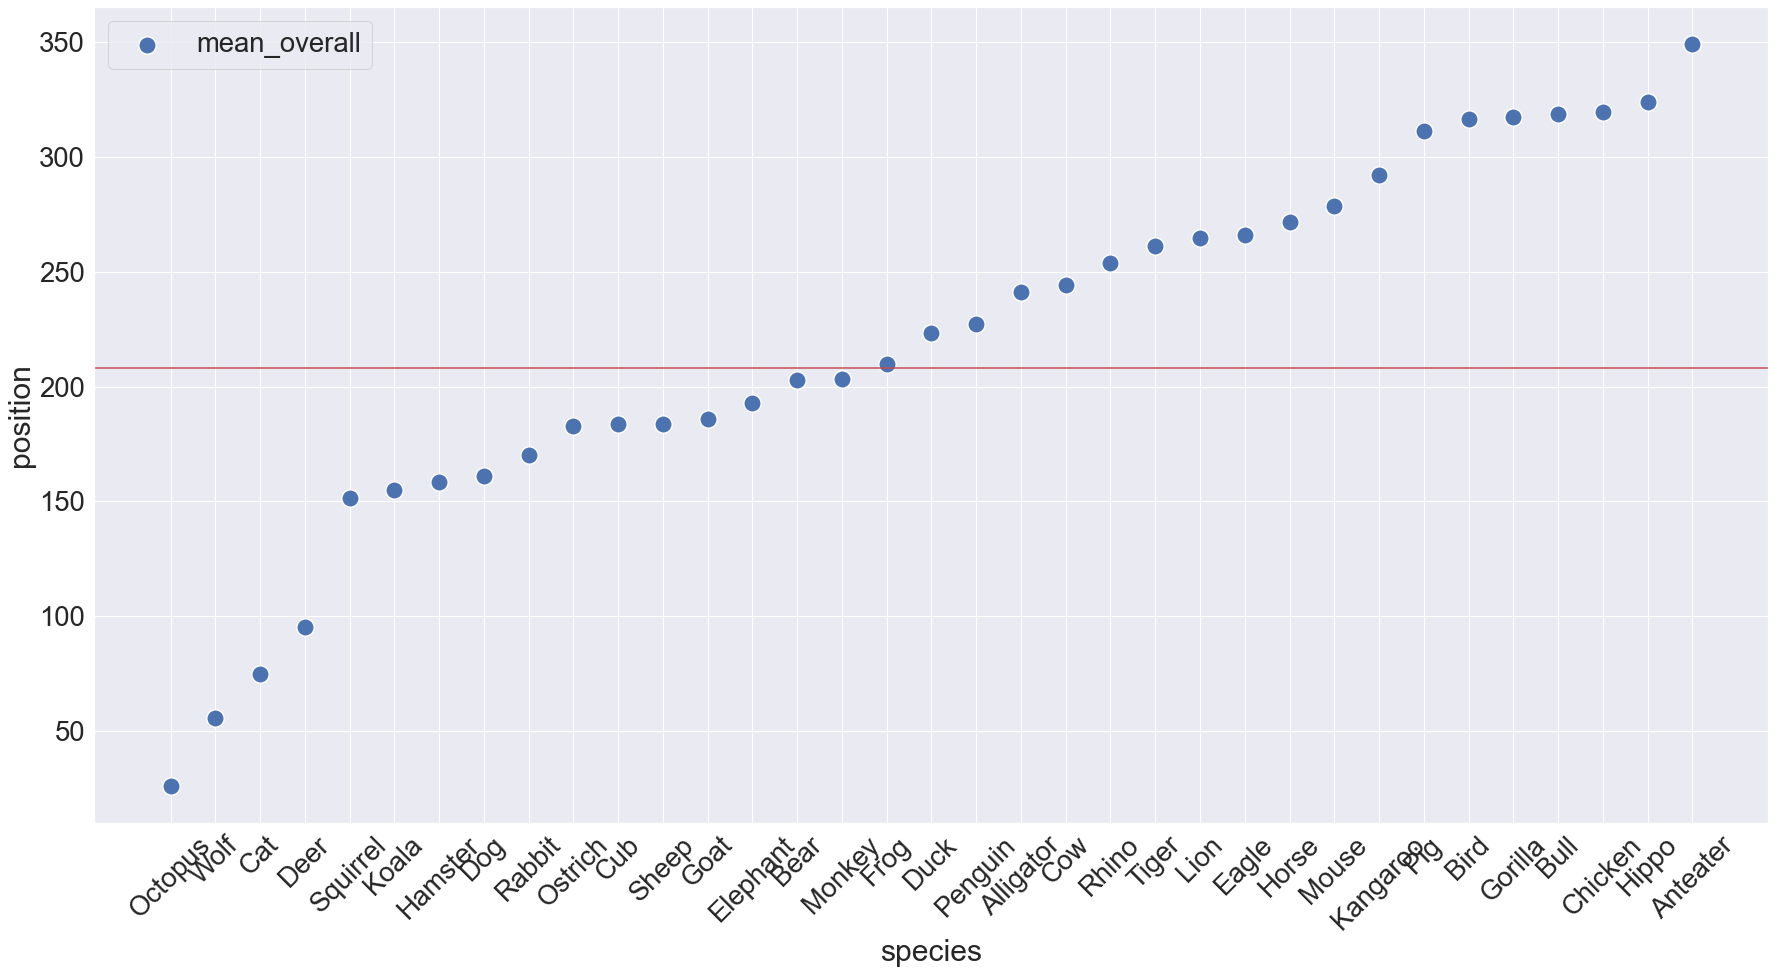

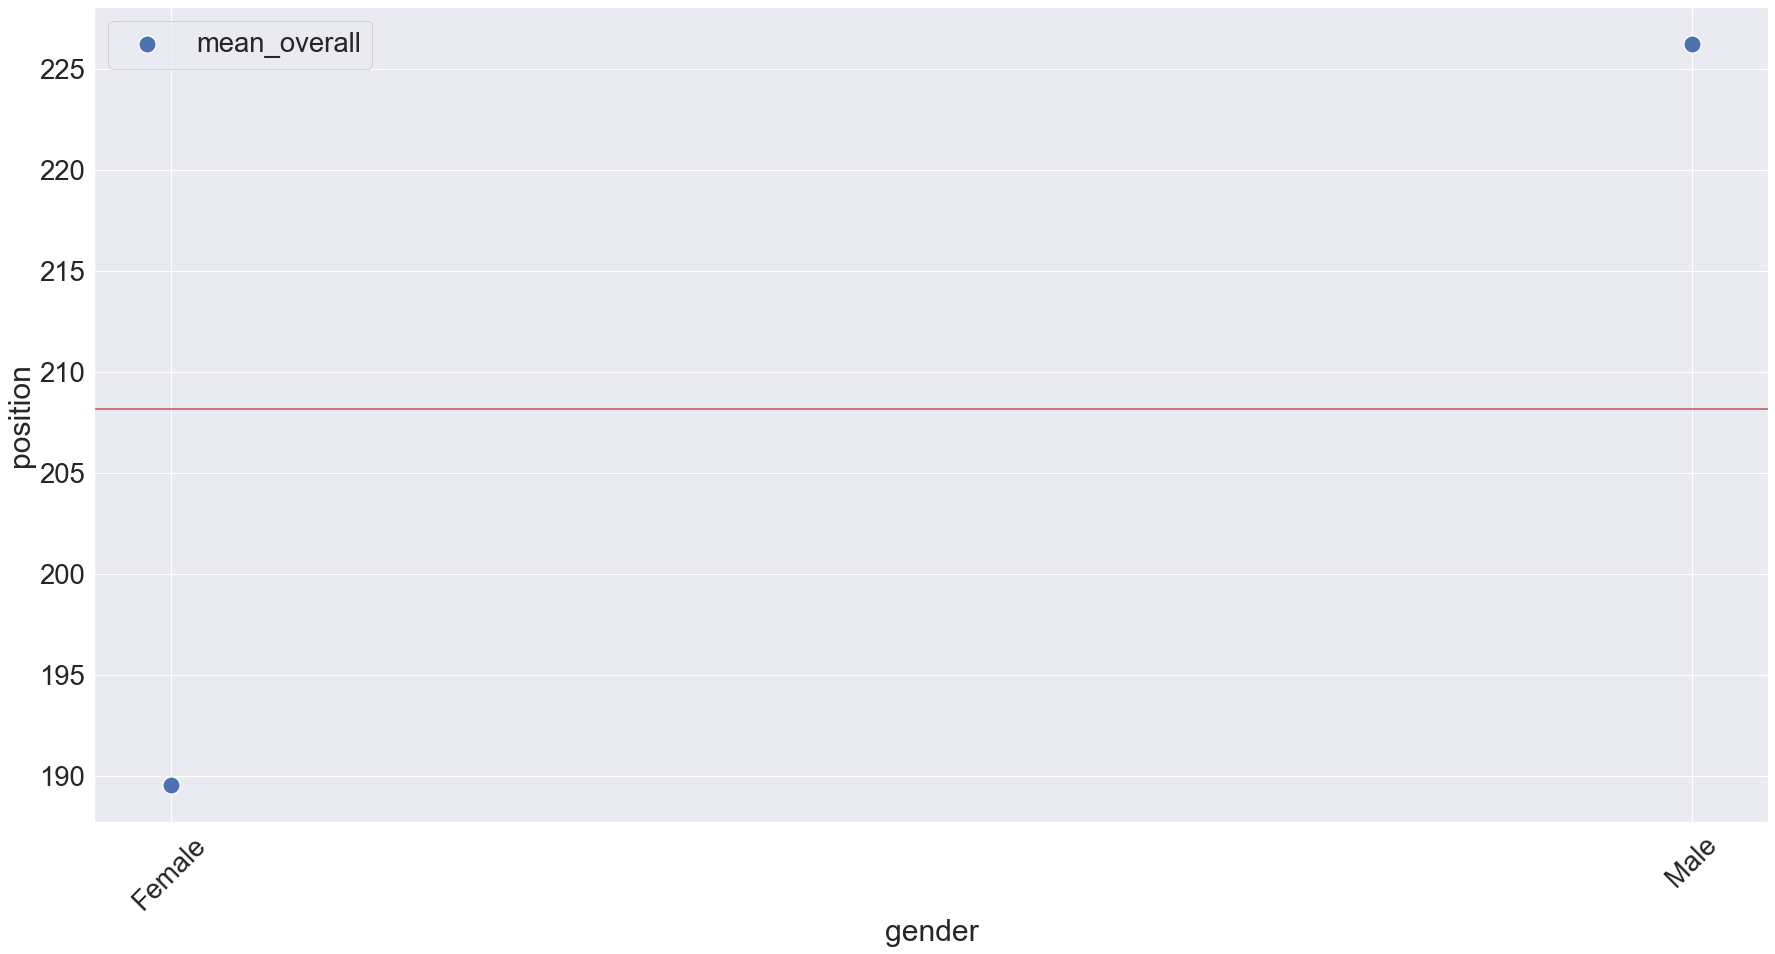

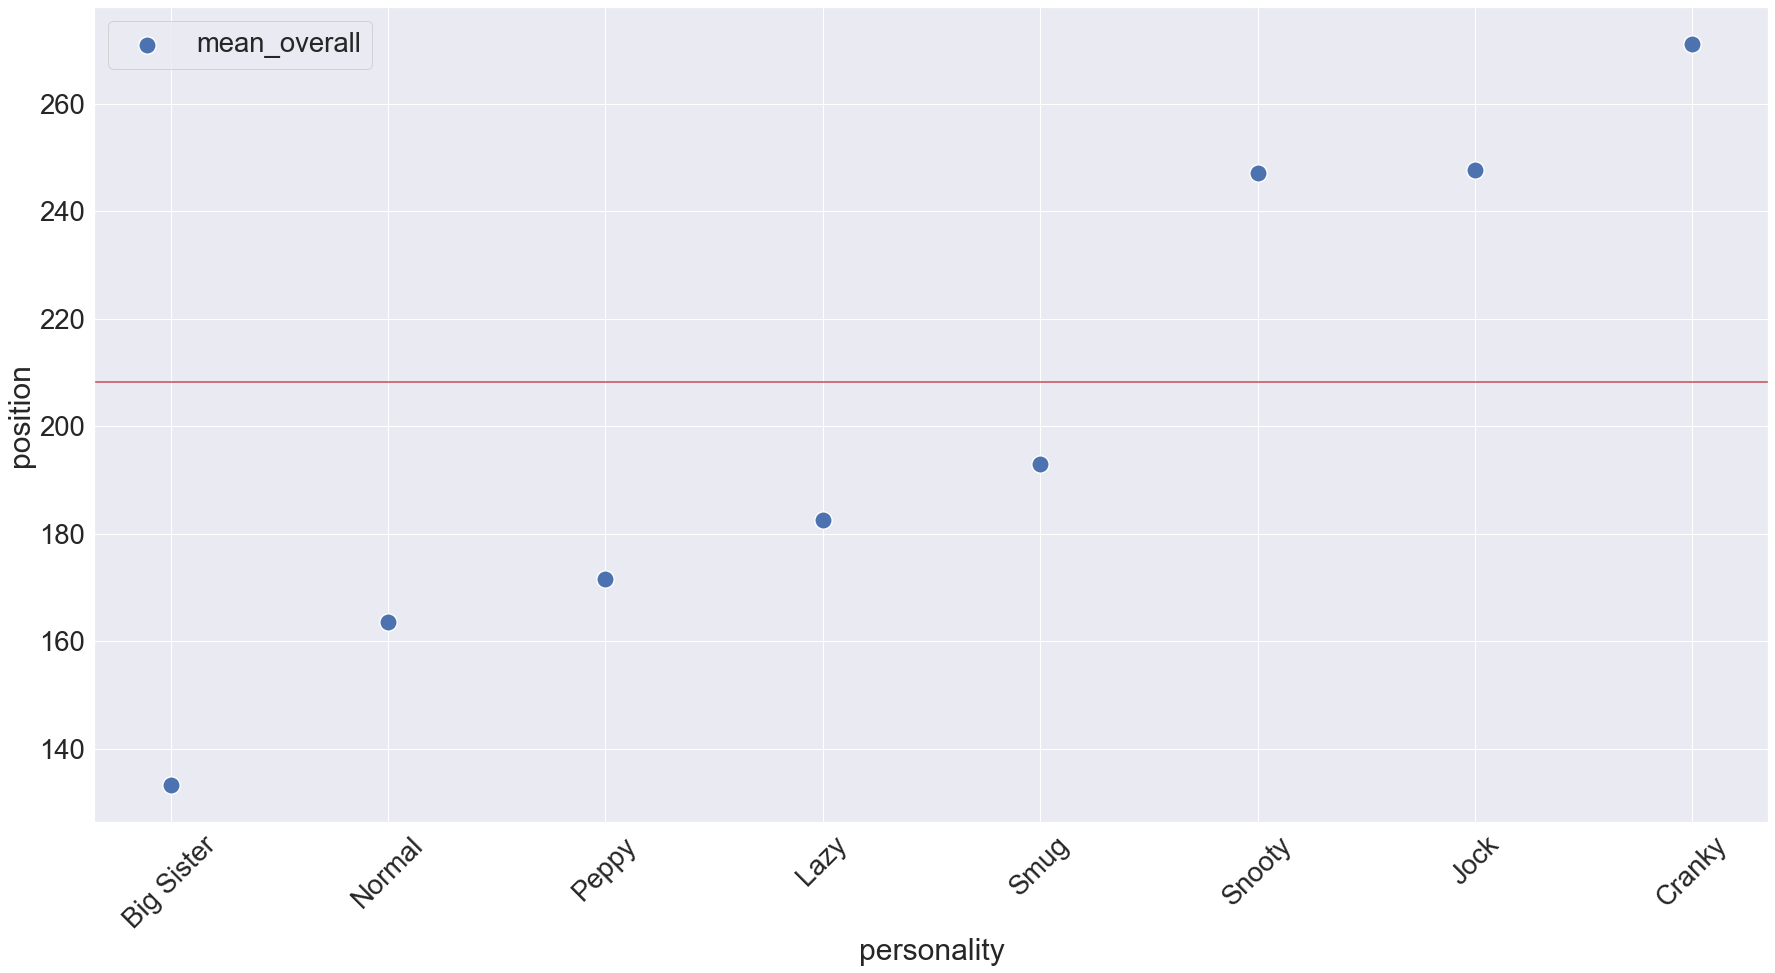

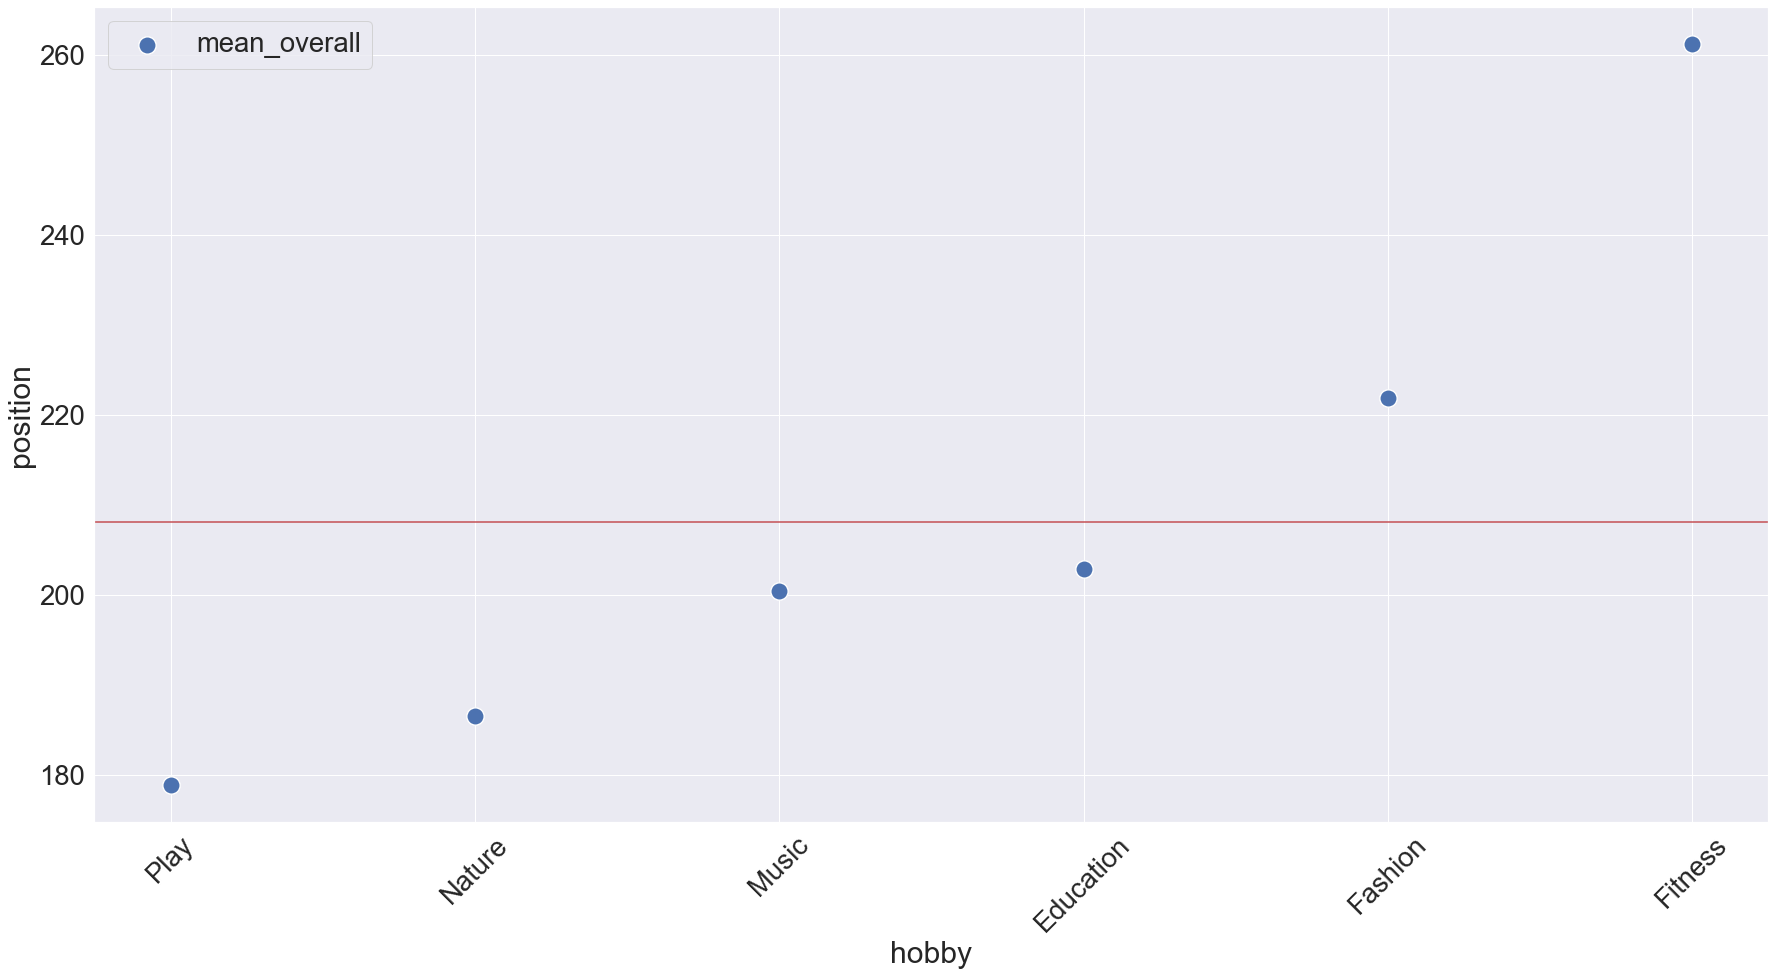

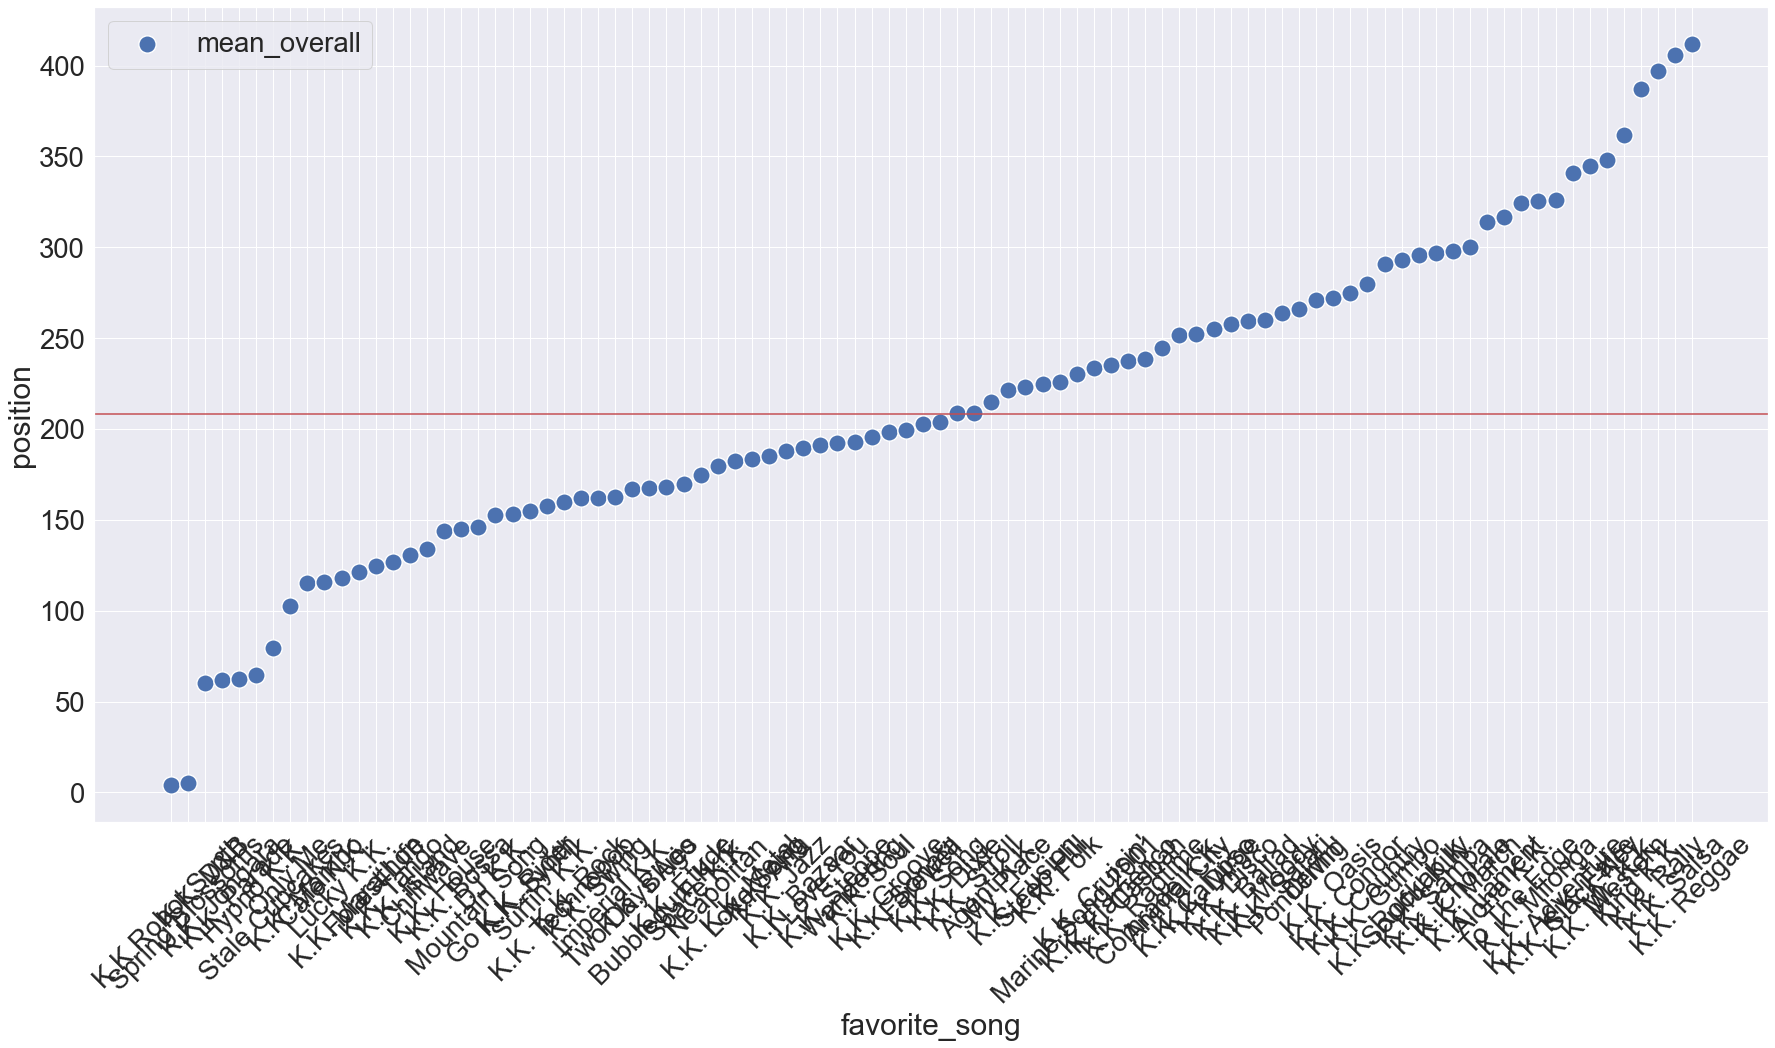

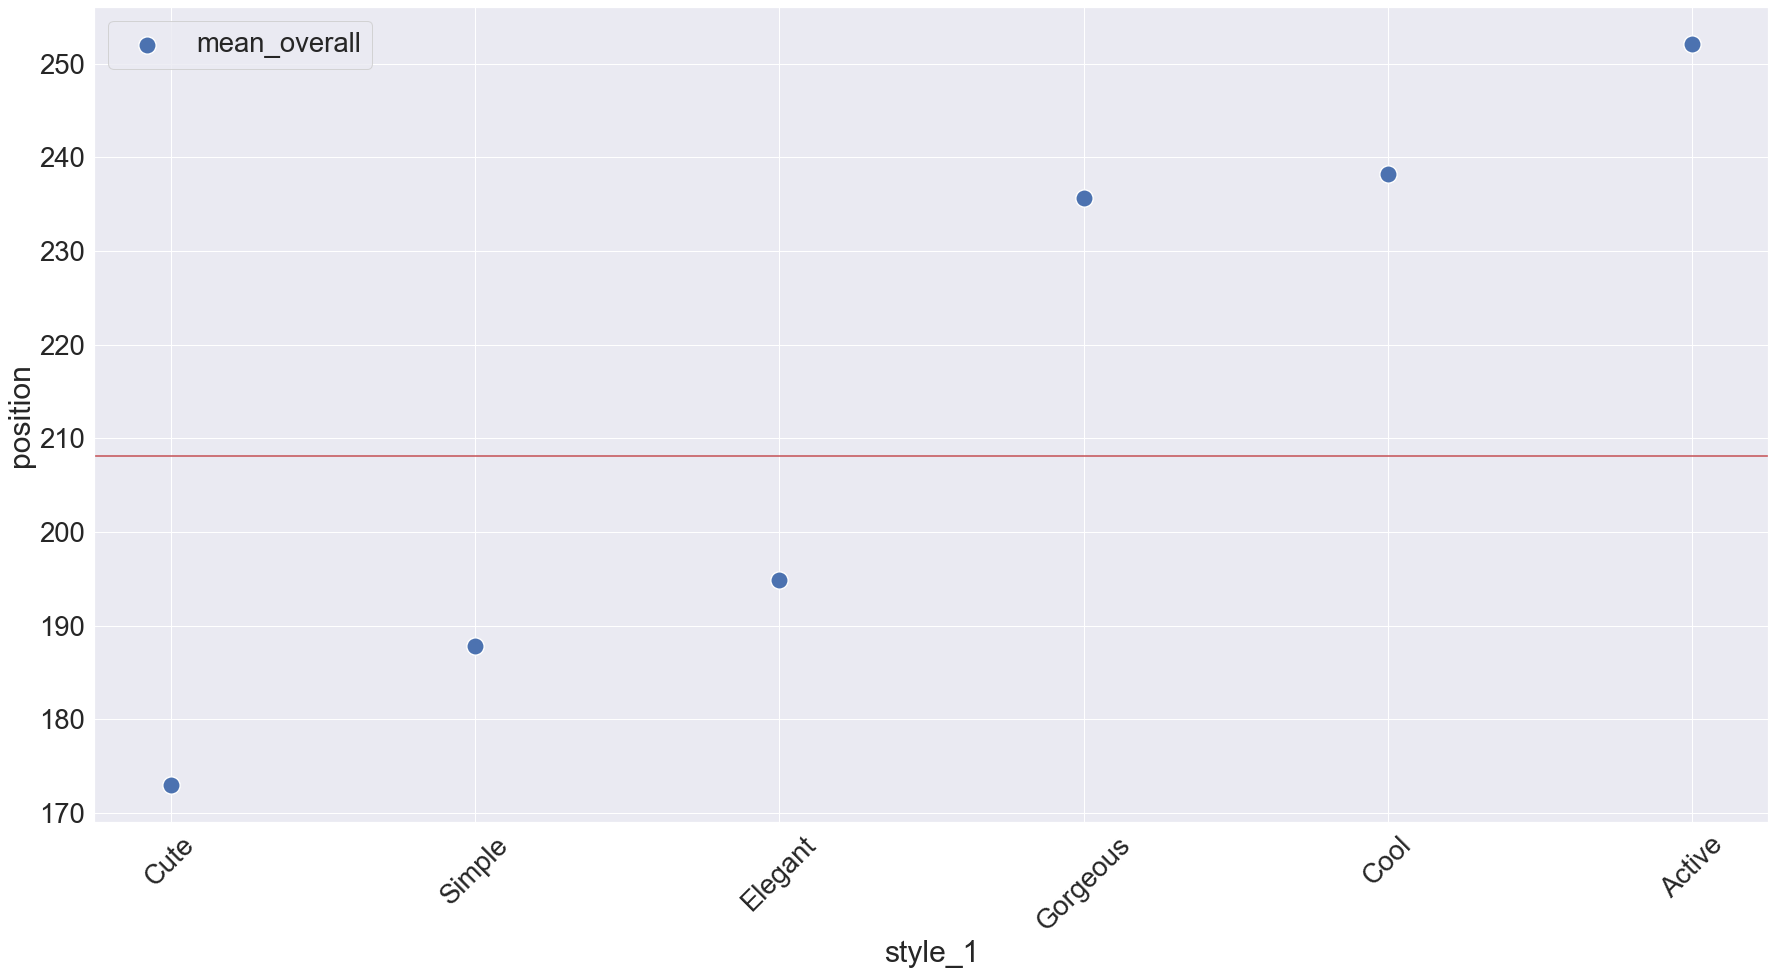

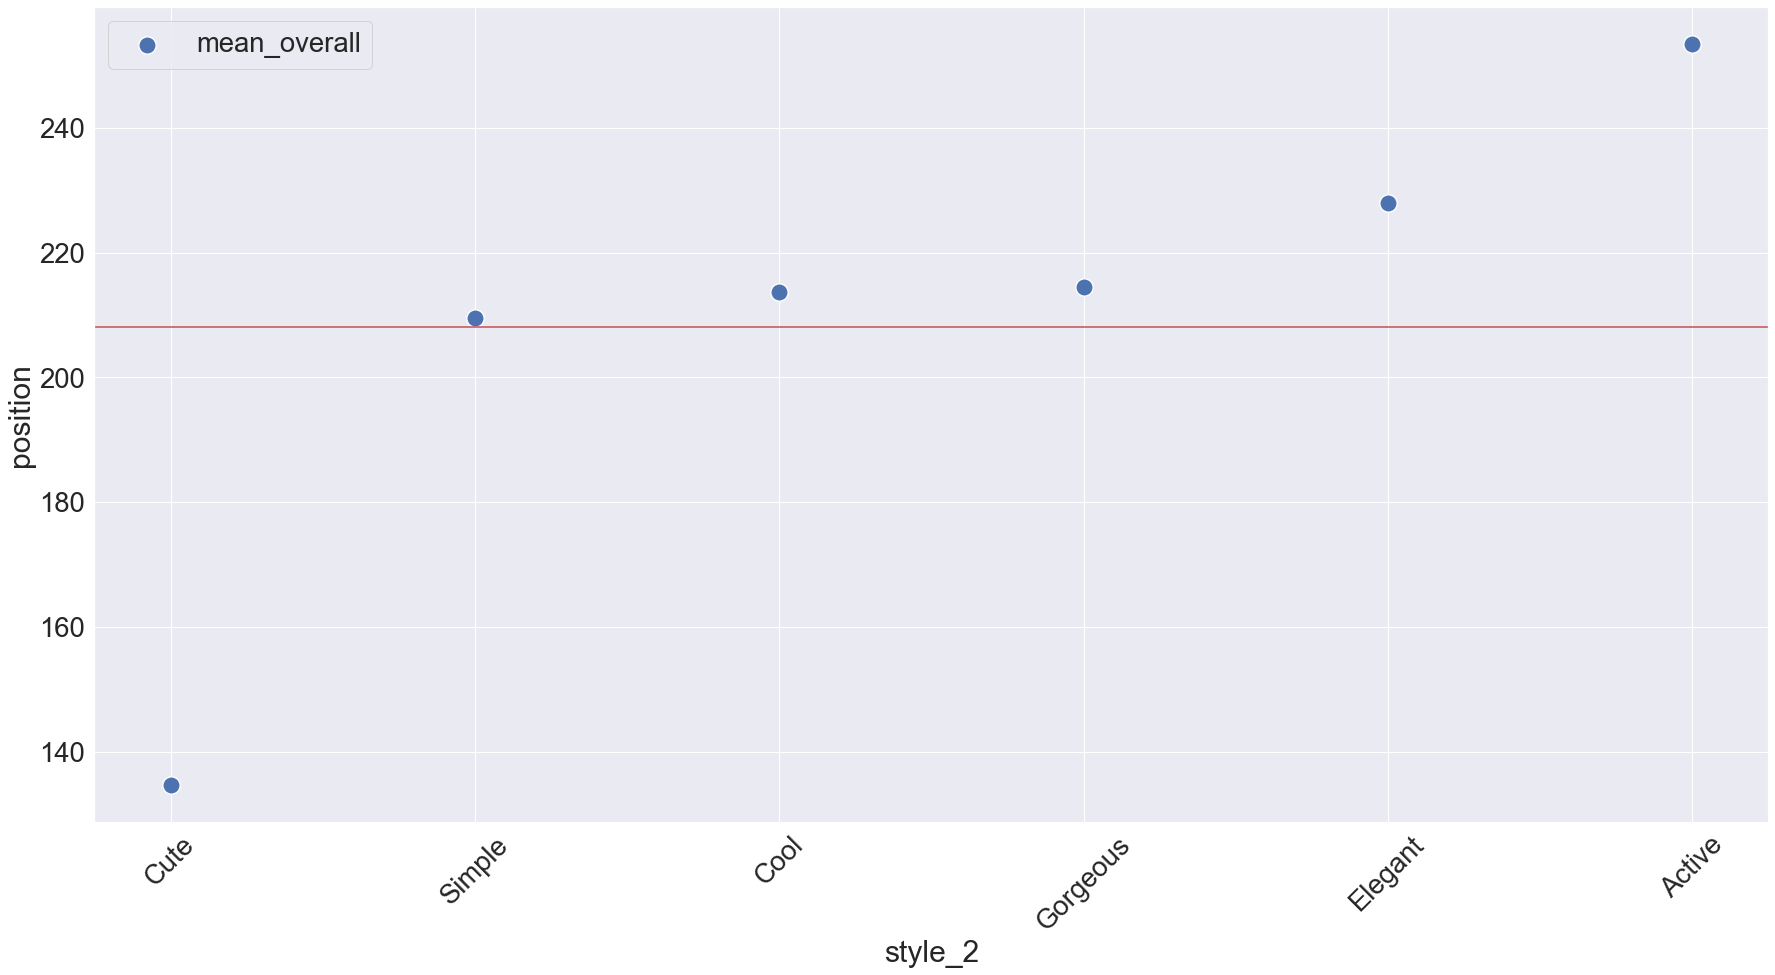

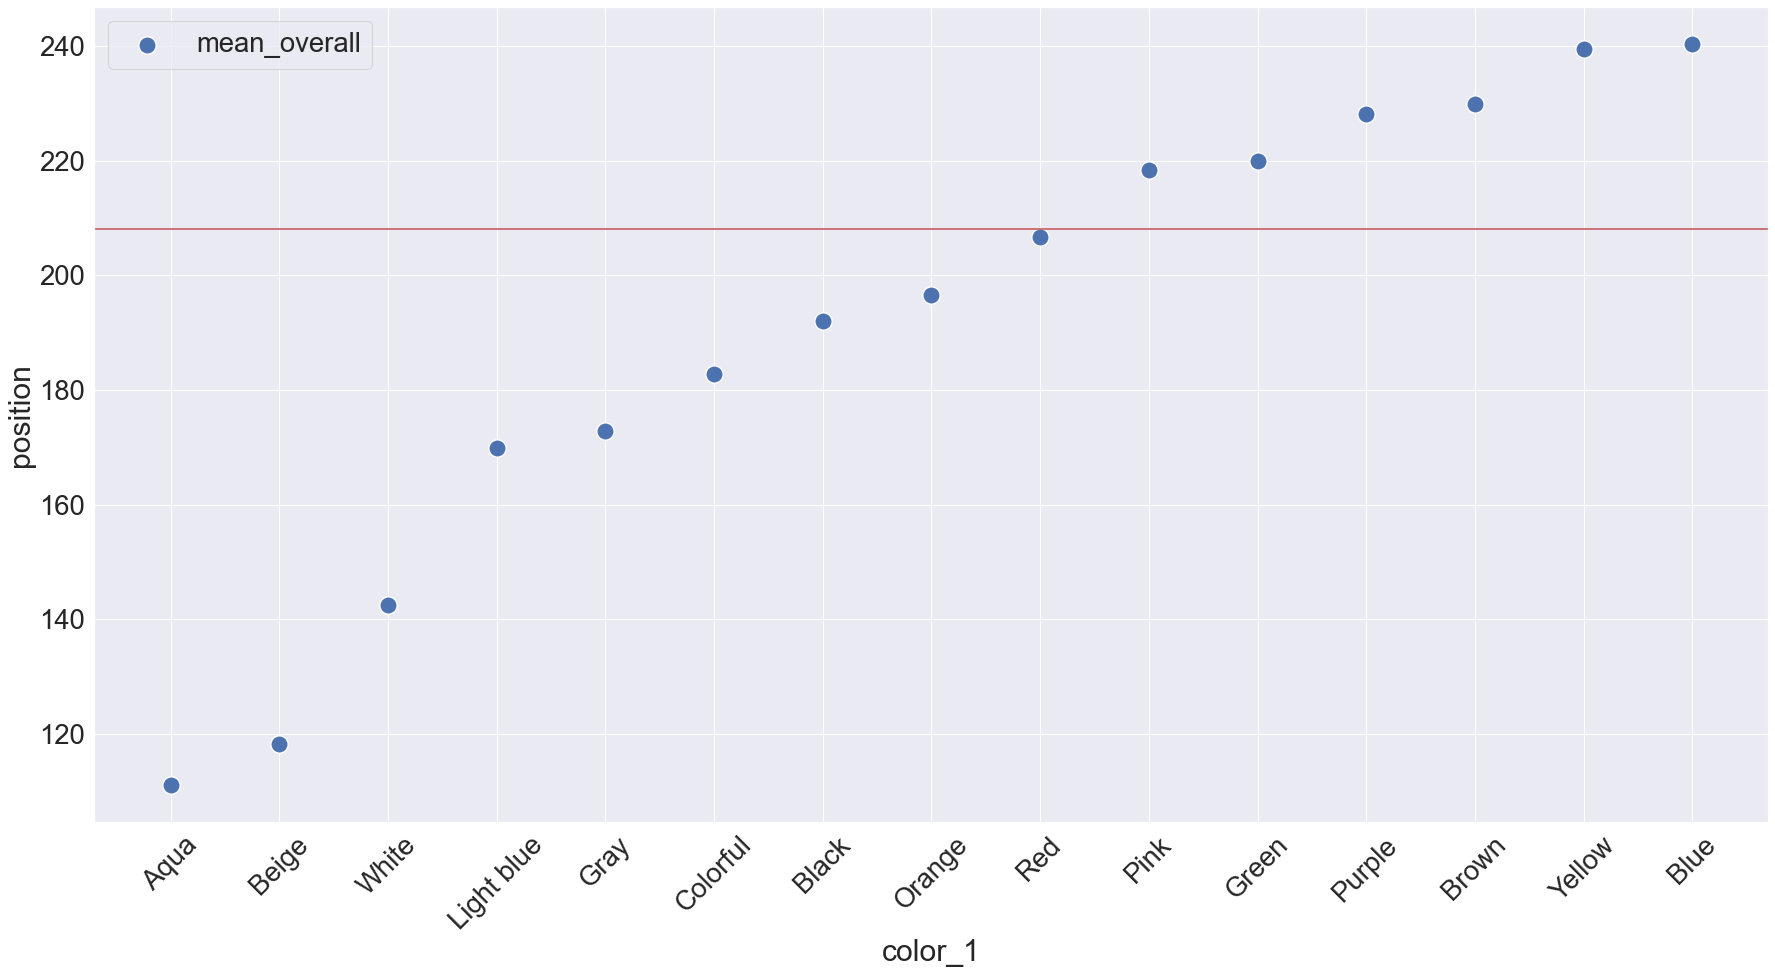

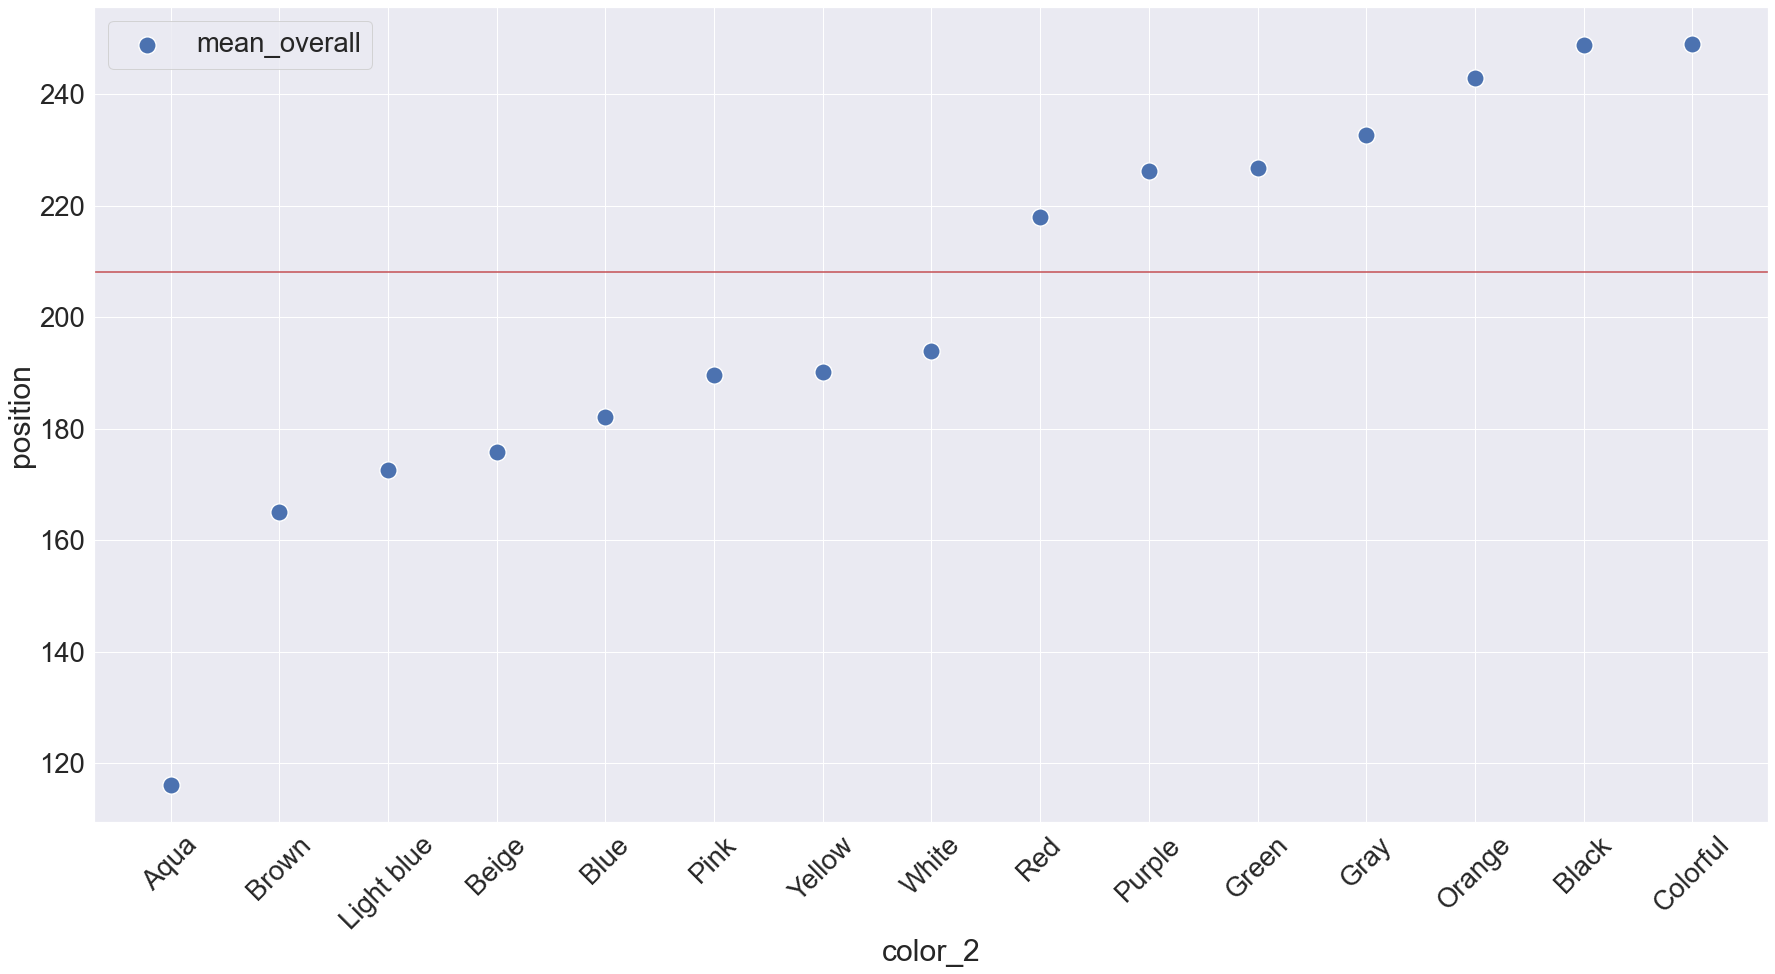

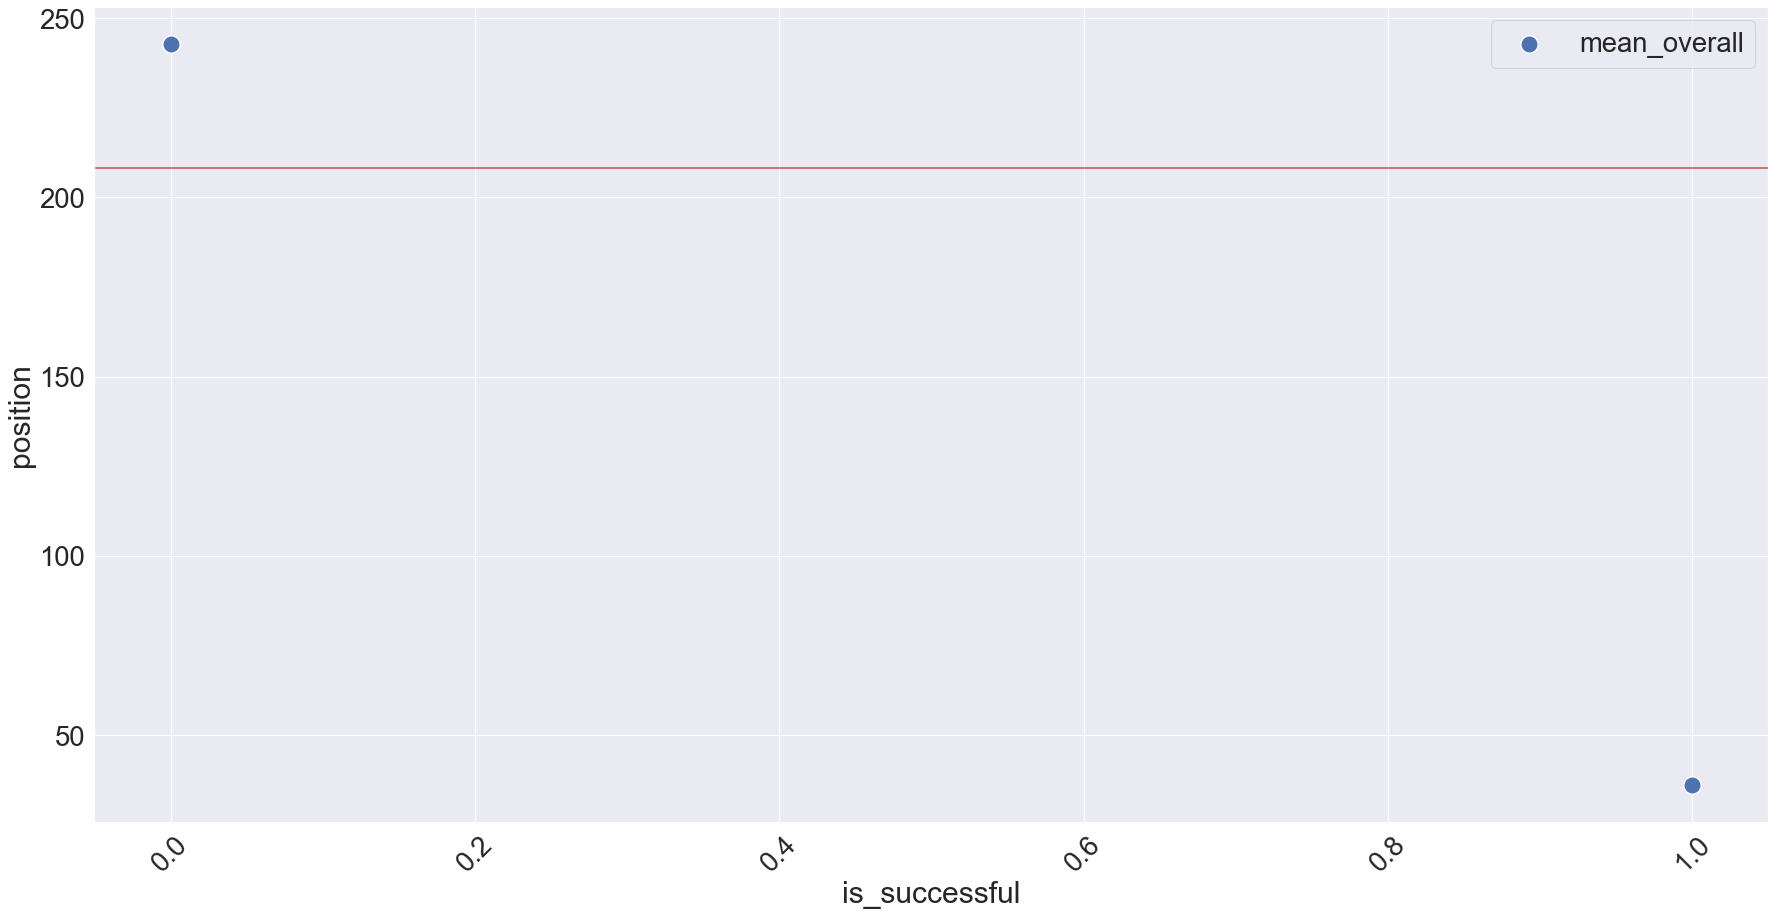

In [43]:
column_scatter_plots()

In [44]:
df.color_2.value_counts()

Red           53
White         51
Blue          39
Yellow        38
Gray          31
Black         27
Pink          26
Green         26
Orange        23
Purple        23
Light blue    21
Brown         19
Beige         18
Colorful      17
Aqua           1
Name: color_2, dtype: int64

In [45]:
df1 = df.copy()

In [46]:
df1.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1
Raymond,2,1,Cat,Male,Smug,Nature,K.K. Cruisin',Elegant,Cool,Black,Gray,1
Shino,3,1,Deer,Female,Peppy,Education,K.K. Folk,Elegant,Gorgeous,Red,Black,1
Sasha,4,1,Rabbit,Male,Lazy,Fashion,K.K Robot Synth,Simple,Cute,Blue,White,1
Zucker,5,1,Octopus,Male,Lazy,Nature,Spring Blossoms,Simple,Cute,Blue,Yellow,1


In [47]:
df1['style_1'] = df1.style_1.str.strip()

In [48]:
df1.style_1.value_counts()

Simple      122
Cool         74
Cute         71
Elegant      57
Active       51
Gorgeous     38
Name: style_1, dtype: int64

In [49]:
def column_scatter_plots():

    for col in train.drop(columns = 'position').columns:
        plt.subplot(6,2)
        sns.set(font_scale=1.4)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        sns.scatterplot(x=col, y=train.position, data=trait_means_dicts(train)[col],label='mean_overall', s=300)

column_scatter_plots()

In [50]:
def column_scatter_plots():
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=1.4)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        sns.scatterplot(x=col, y='position', data=trait_means_dicts(train)[col],label='mean_overall', s=300)

In [51]:
def scatters():
    plt.figure(figsize = (10,40))
    ct = 0 
    for col in train.drop(columns = 'position').columns:
        ct += 1
        plt.subplot(8,2,ct)
        ax =  sns.scatterplot(x=col, y='position', data=trait_means_dicts(train)[col],label='mean_overall', s=15)
        sns.set(font_scale=1.4)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        
    plt.tight_layout()

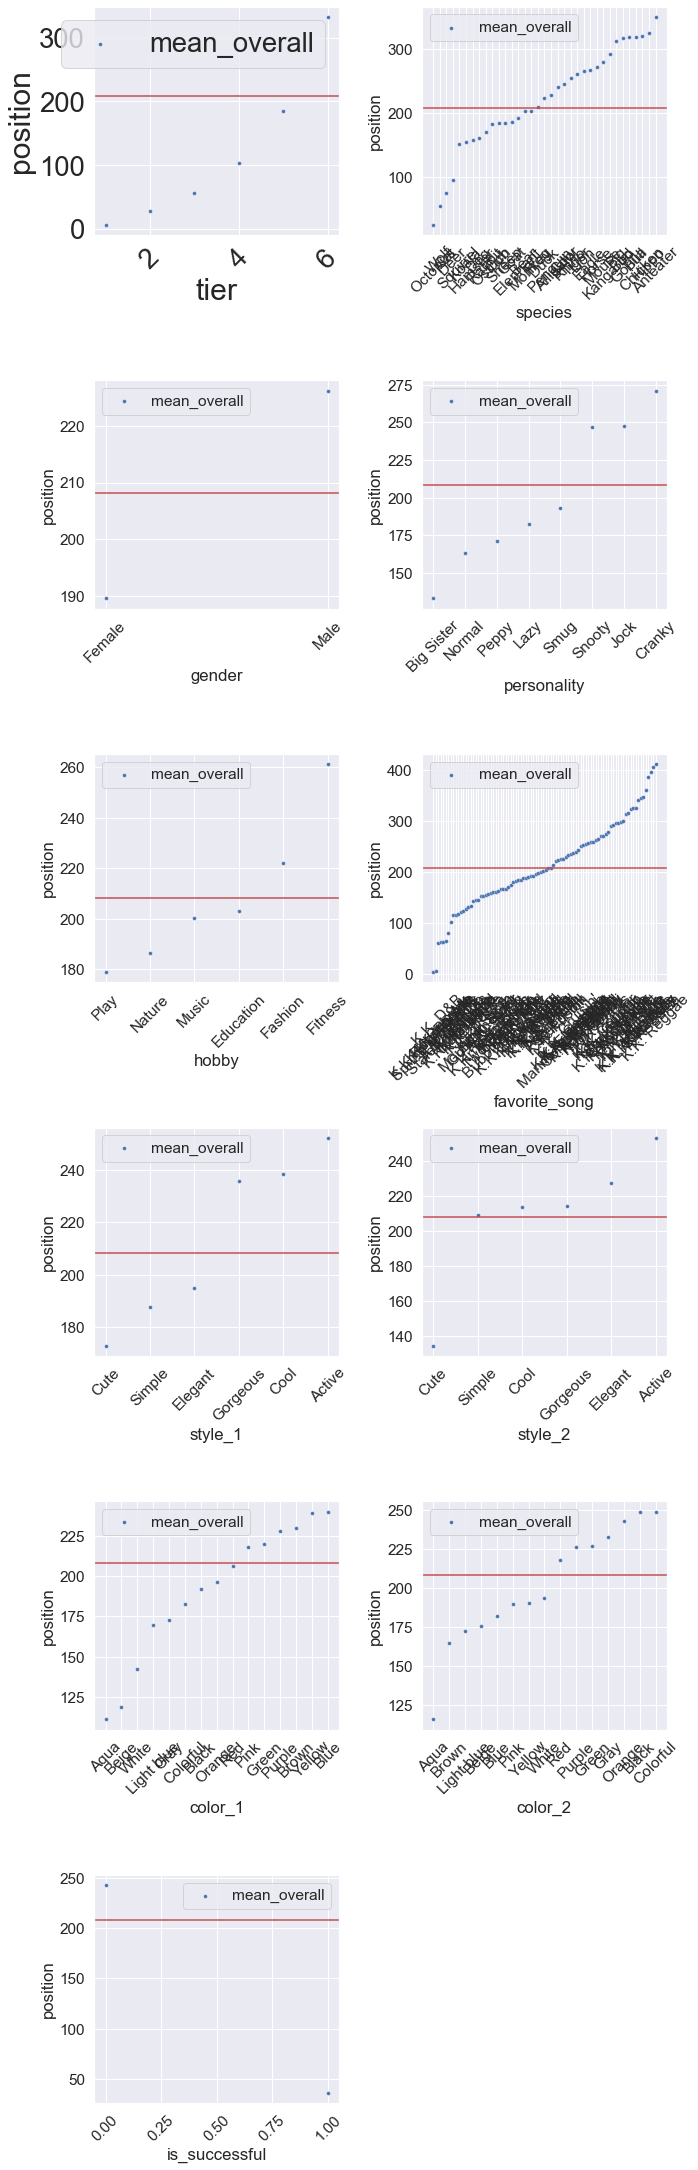

In [52]:
scatters()

In [53]:
species_perc = train.groupby(['species'])
species_perc = round(species_perc.mean().is_successful*100,2)
species_perc

species
Alligator                   0.00
Anteater                    0.00
Bear                        0.00
Bird                        0.00
Bull                        0.00
Cat                        64.71
Chicken                     0.00
Cow                         0.00
Cub                        20.00
Deer                       60.00
Dog                        23.08
Duck                        9.09
Eagle                       0.00
Elephant                   11.11
Frog                        7.14
Goat                       25.00
Gorilla                     0.00
Hamster                    40.00
Hippo                       0.00
Horse                       8.33
Kangaroo                    0.00
Koala                      16.67
Lion                        0.00
Monkey                      0.00
Mouse                      12.50
Octopus                   100.00
Ostrich                     0.00
Penguin                     0.00
Pig                         0.00
Rabbit                     17.65
Rh

In [54]:
train.groupby('species').is_successful.value_counts()

species    is_successful
Alligator  0                 6
Anteater   0                 2
Bear       0                 7
Bird       0                11
Bull       0                 4
Cat        1                11
           0                 6
Chicken    0                 6
Cow        0                 4
Cub        0                 8
           1                 2
Deer       1                 6
           0                 4
Dog        0                10
           1                 3
Duck       0                10
           1                 1
Eagle      0                 8
Elephant   0                 8
           1                 1
Frog       0                13
           1                 1
Goat       0                 3
           1                 1
Gorilla    0                 5
Hamster    0                 3
           1                 2
Hippo      0                 5
Horse      0                11
           1                 1
Kangaroo   0                 5
Koala      0  

In [55]:
successful_chars = train.groupby('is_successful')
successful_chars

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

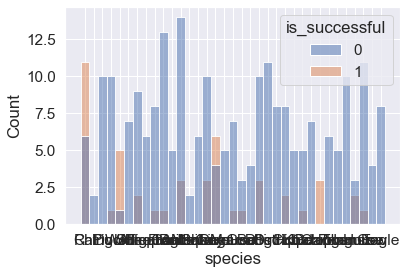

In [56]:
sns.histplot(data = train, x = 'species', hue = 'is_successful')
plt.plot

In [57]:
def column_hist_plots():
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        sns.histplot(data = train, x = col, hue = 'is_successful')

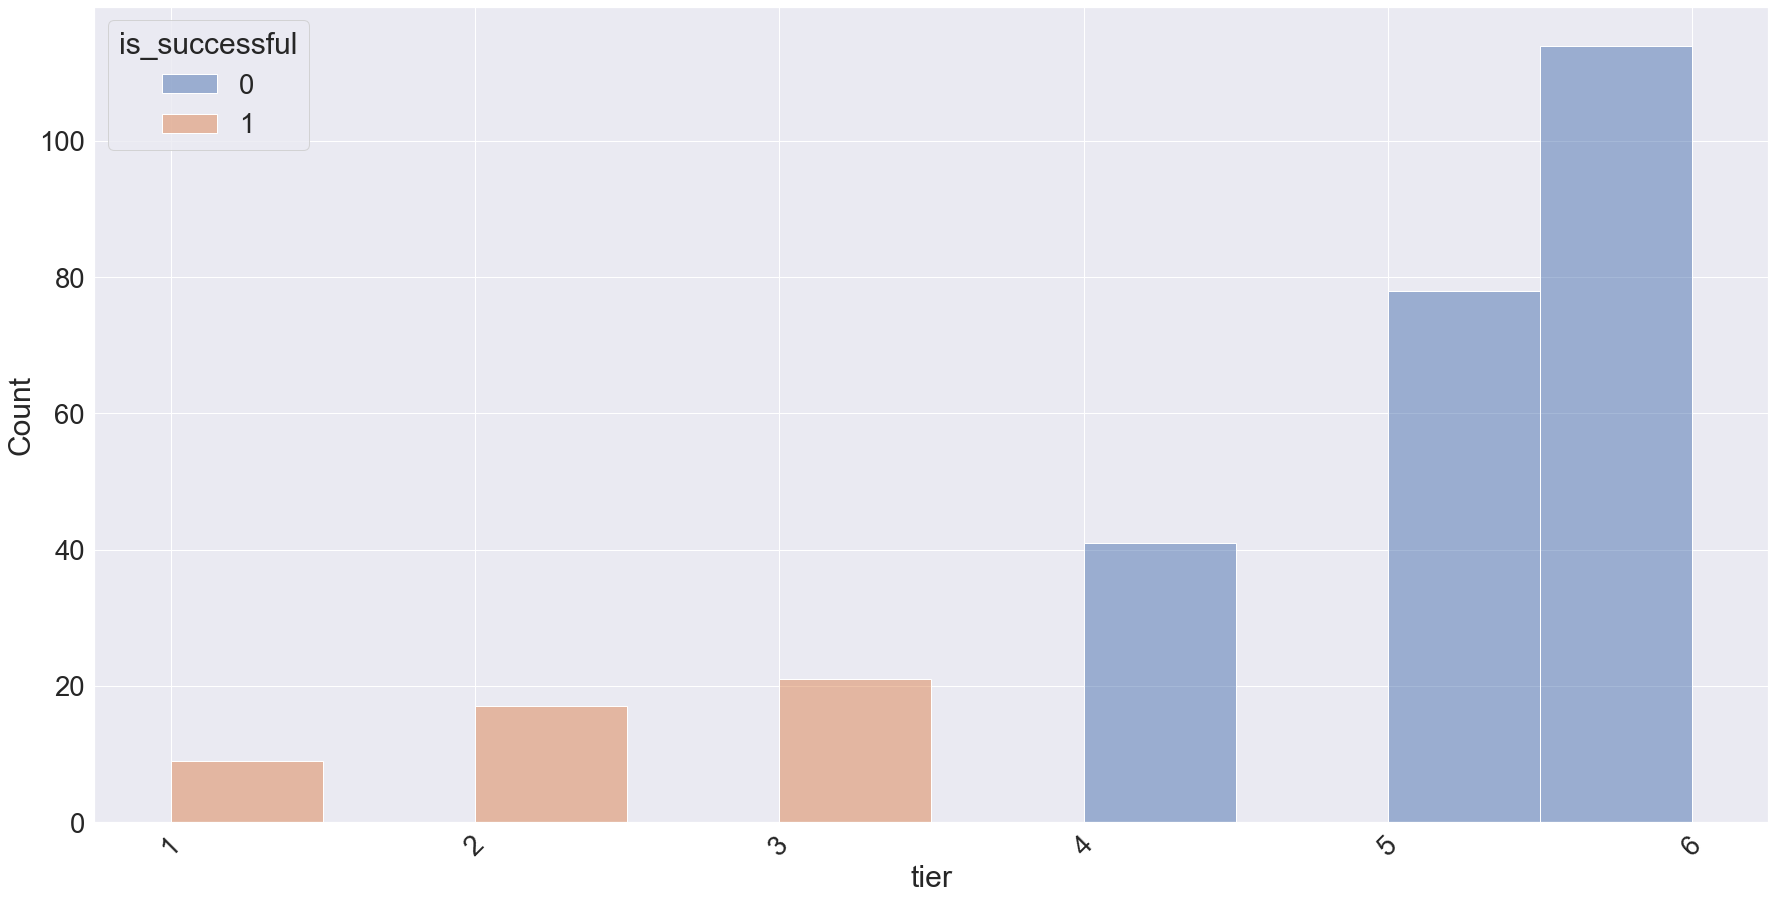

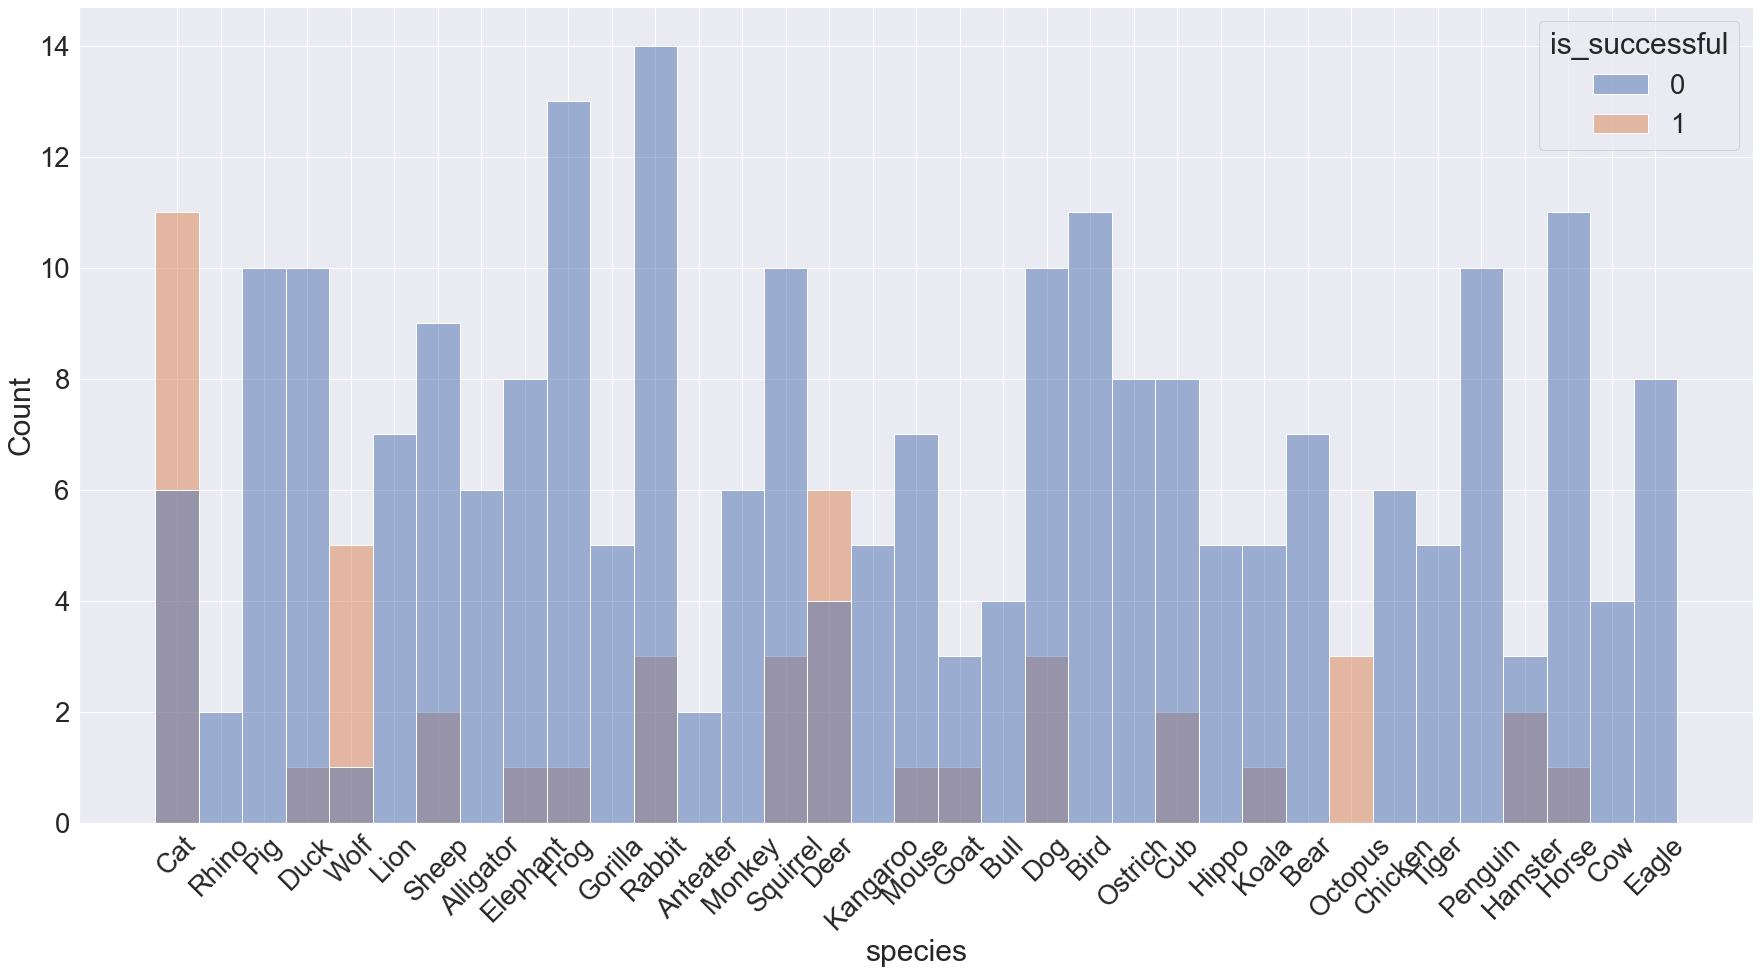

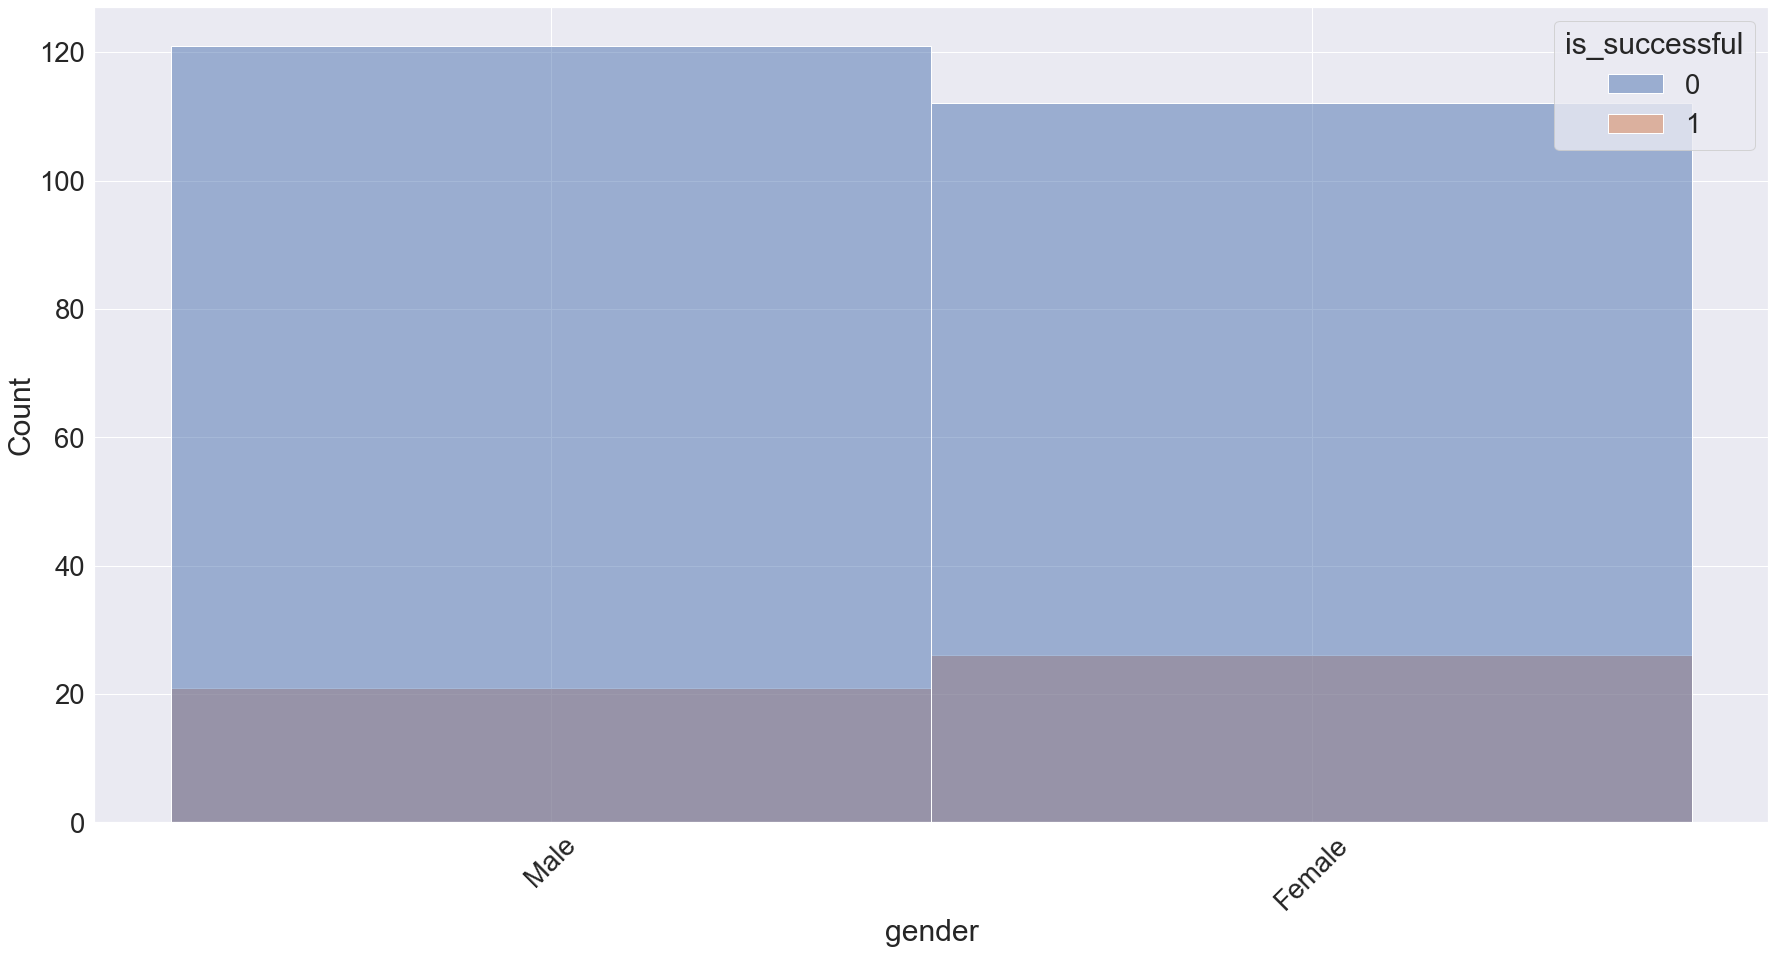

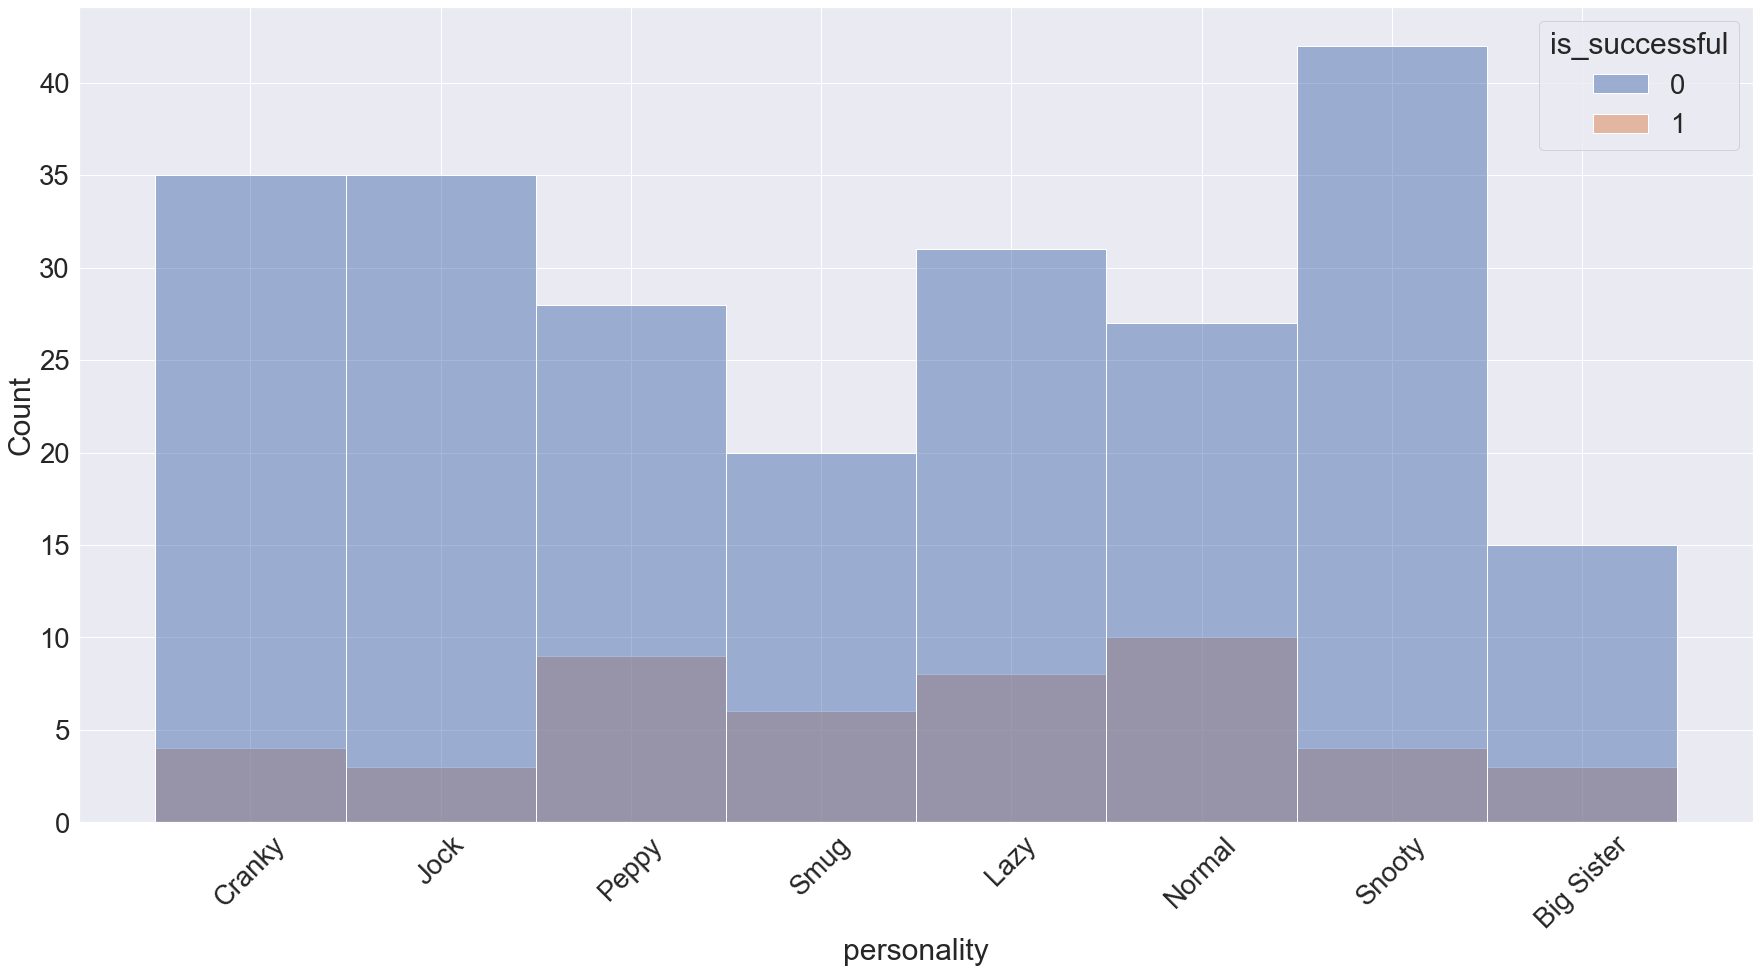

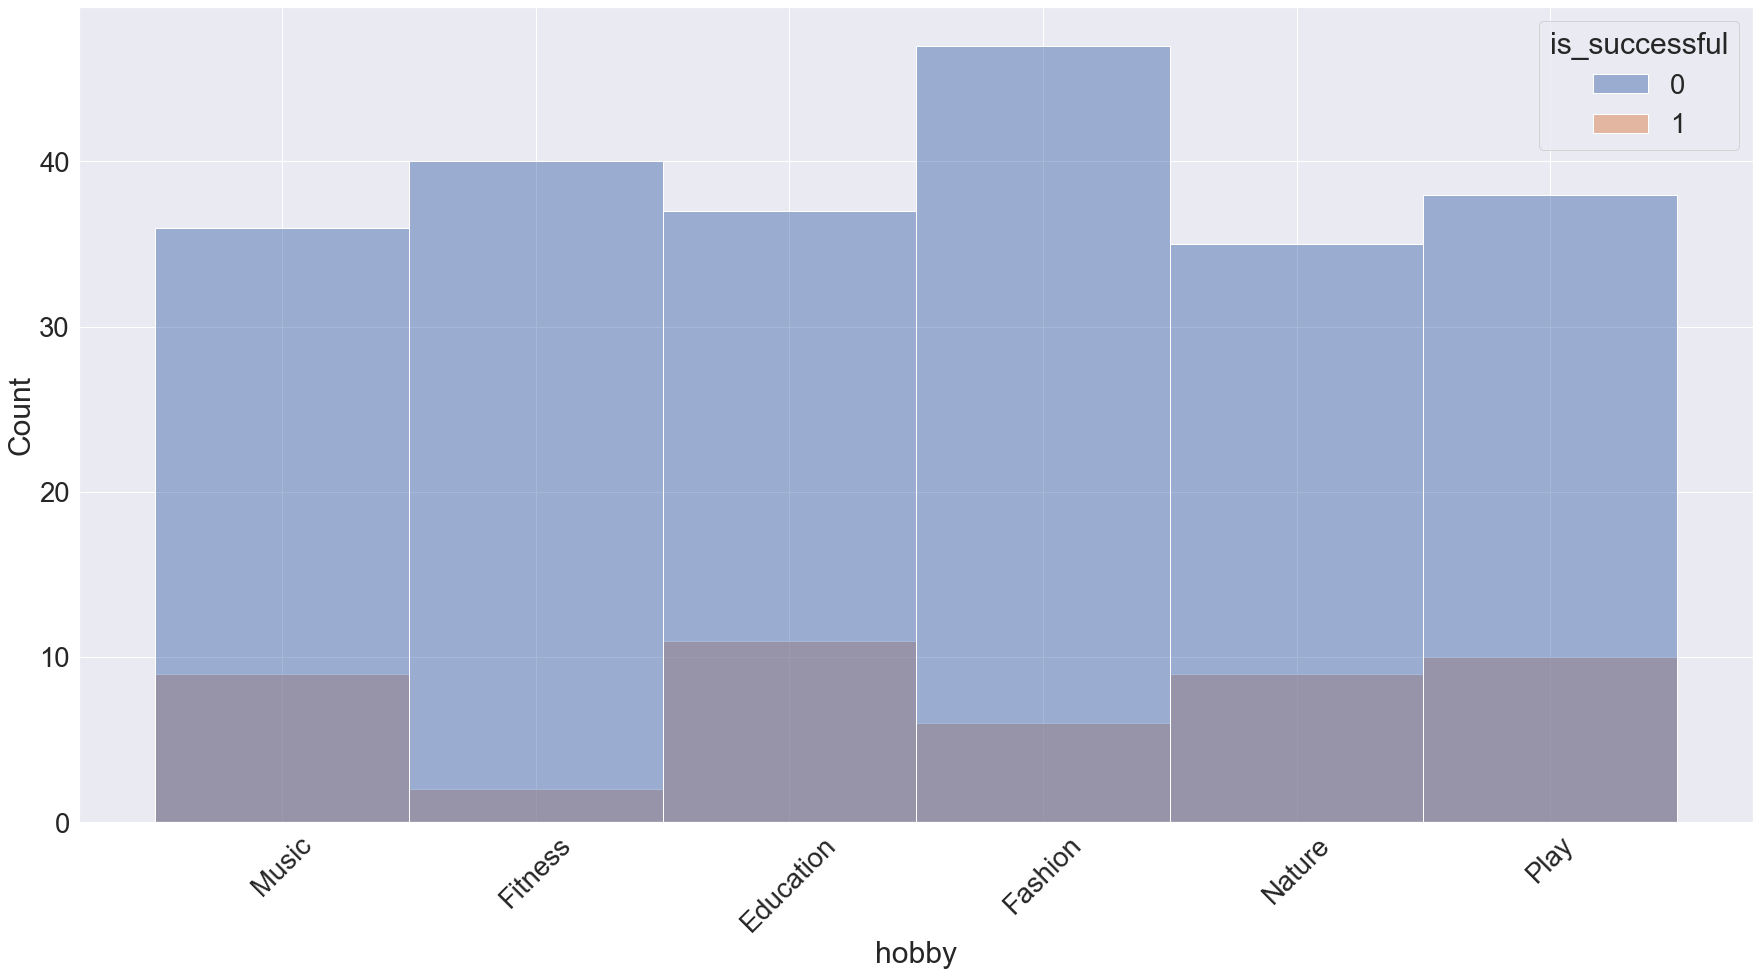

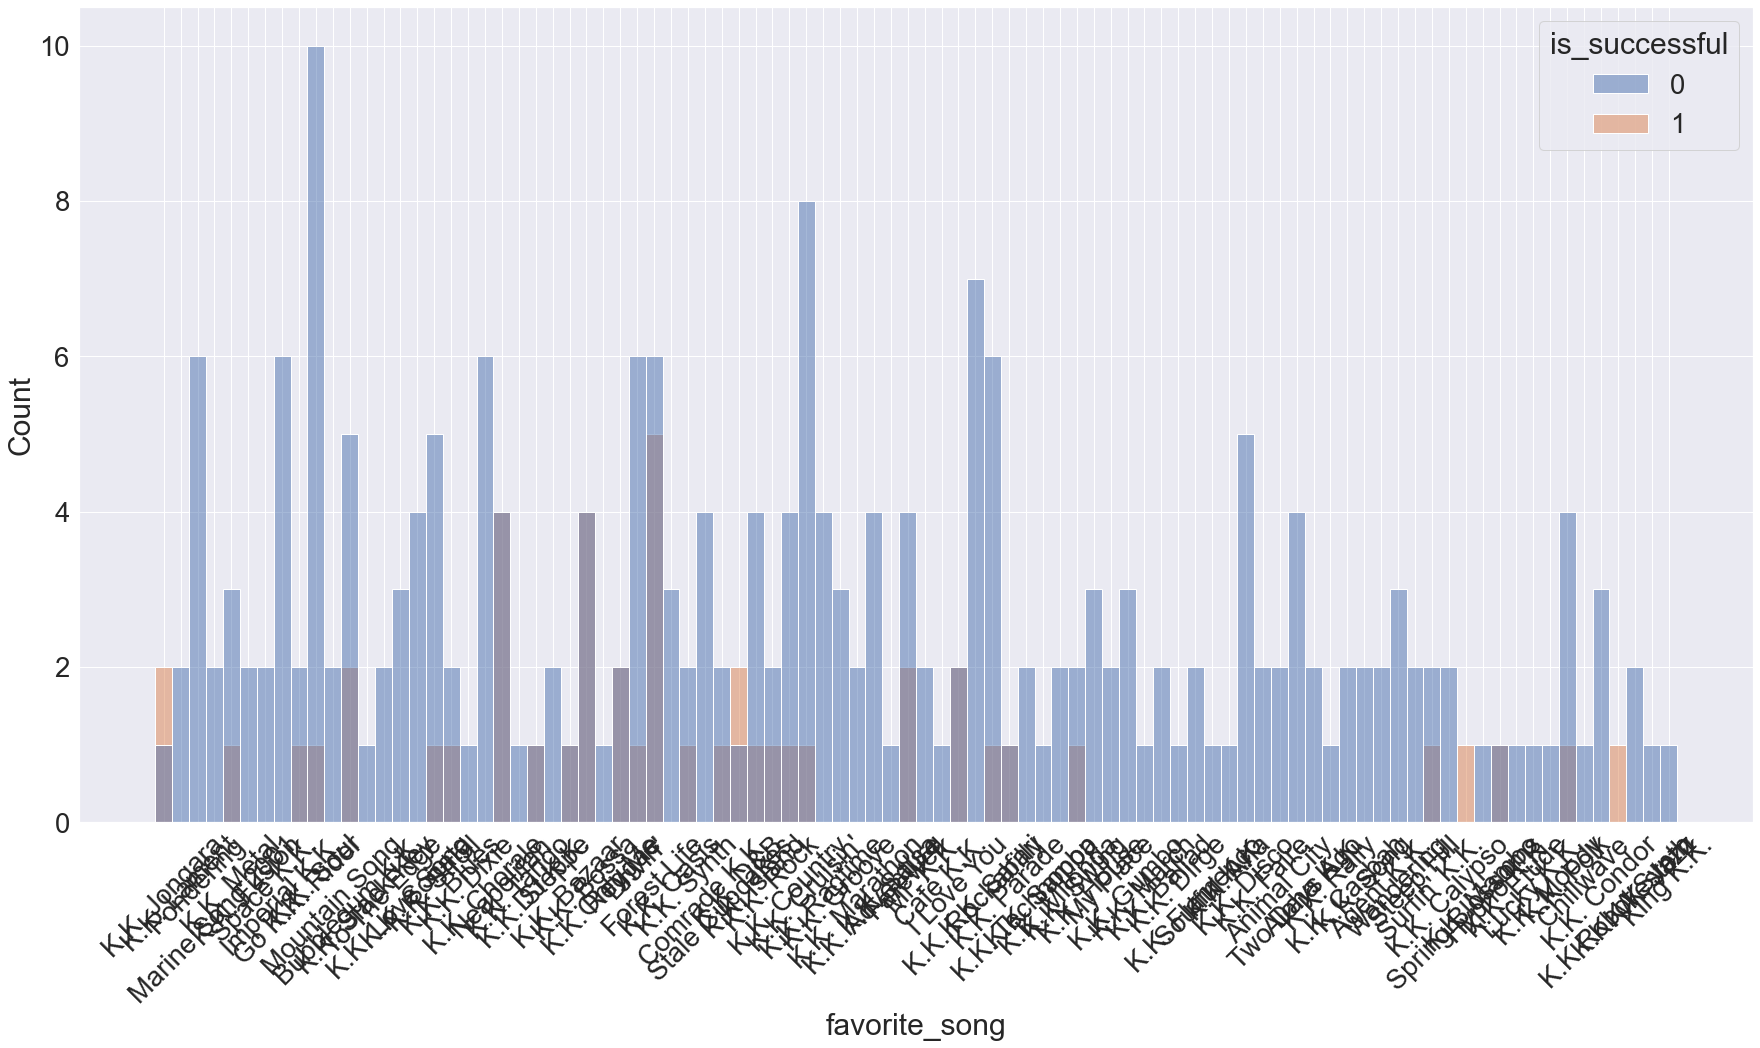

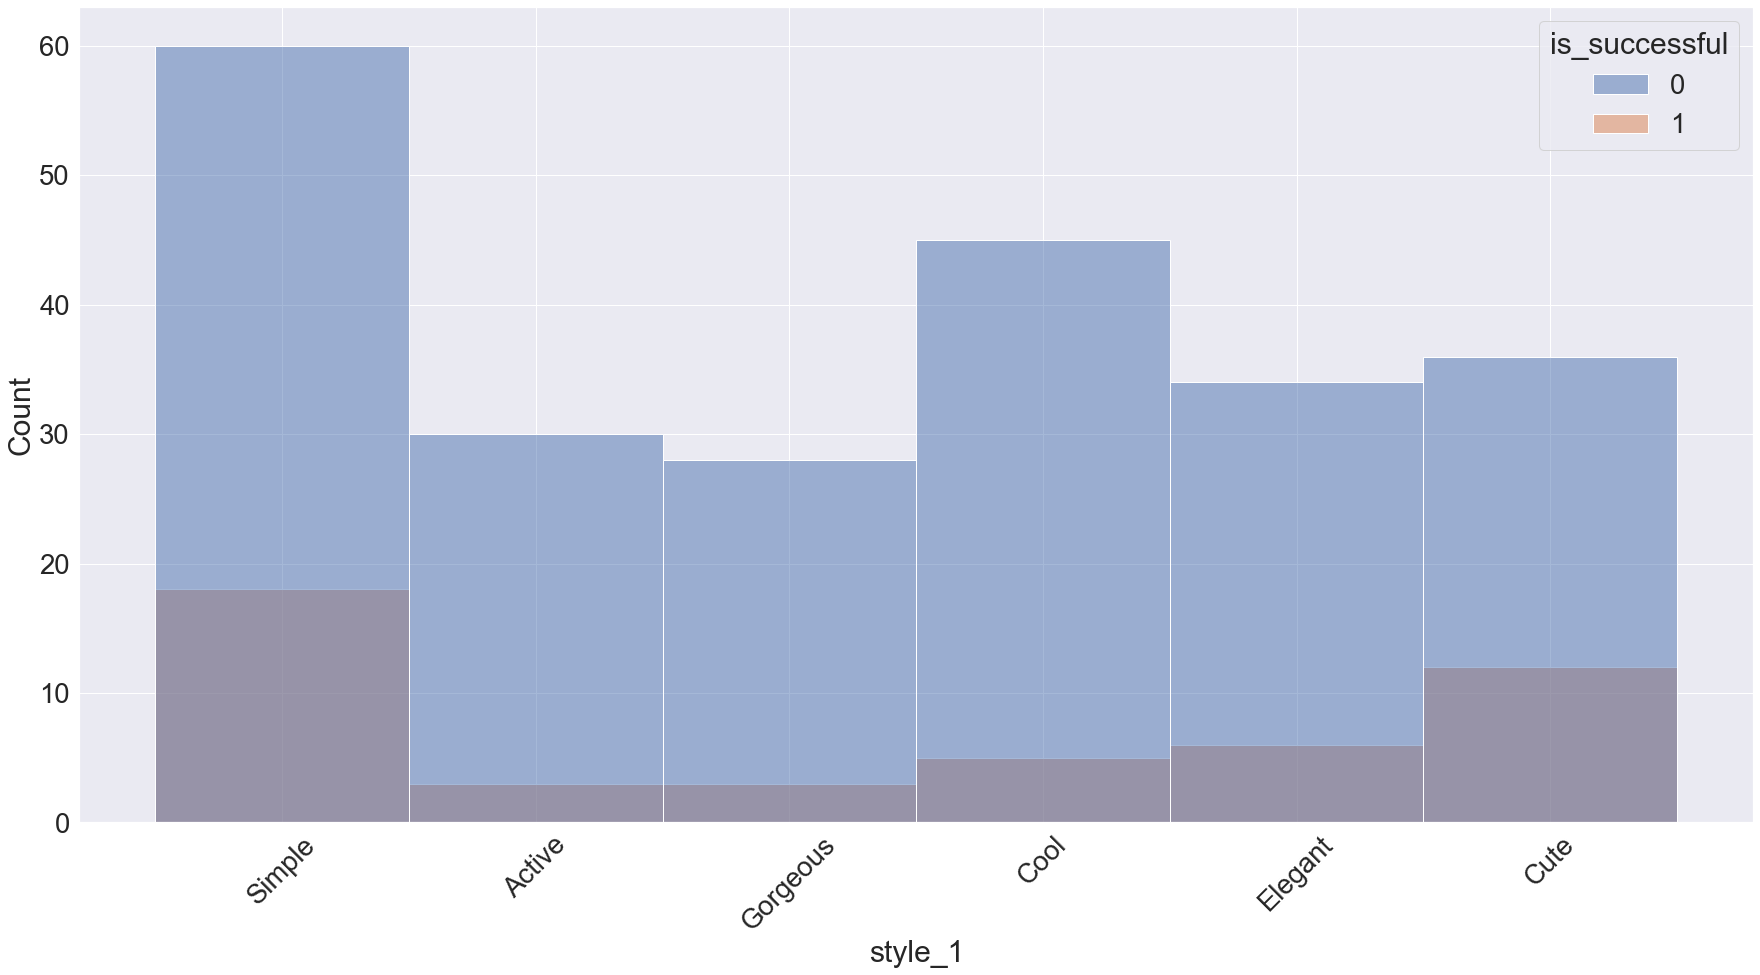

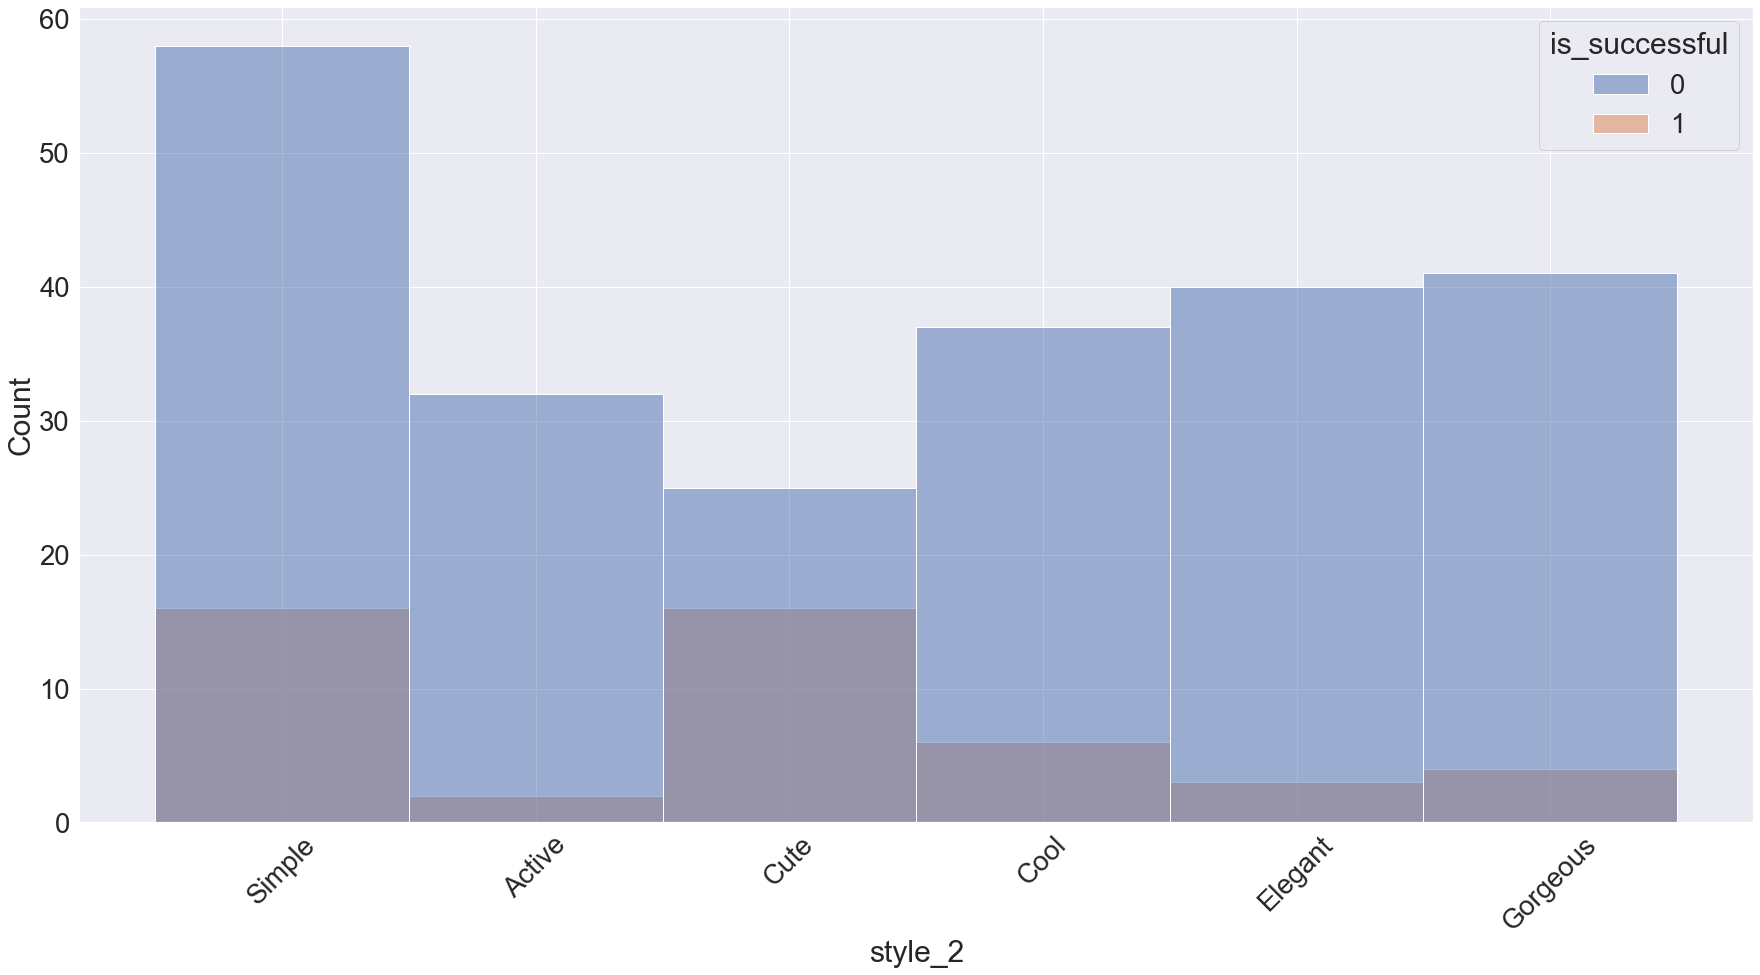

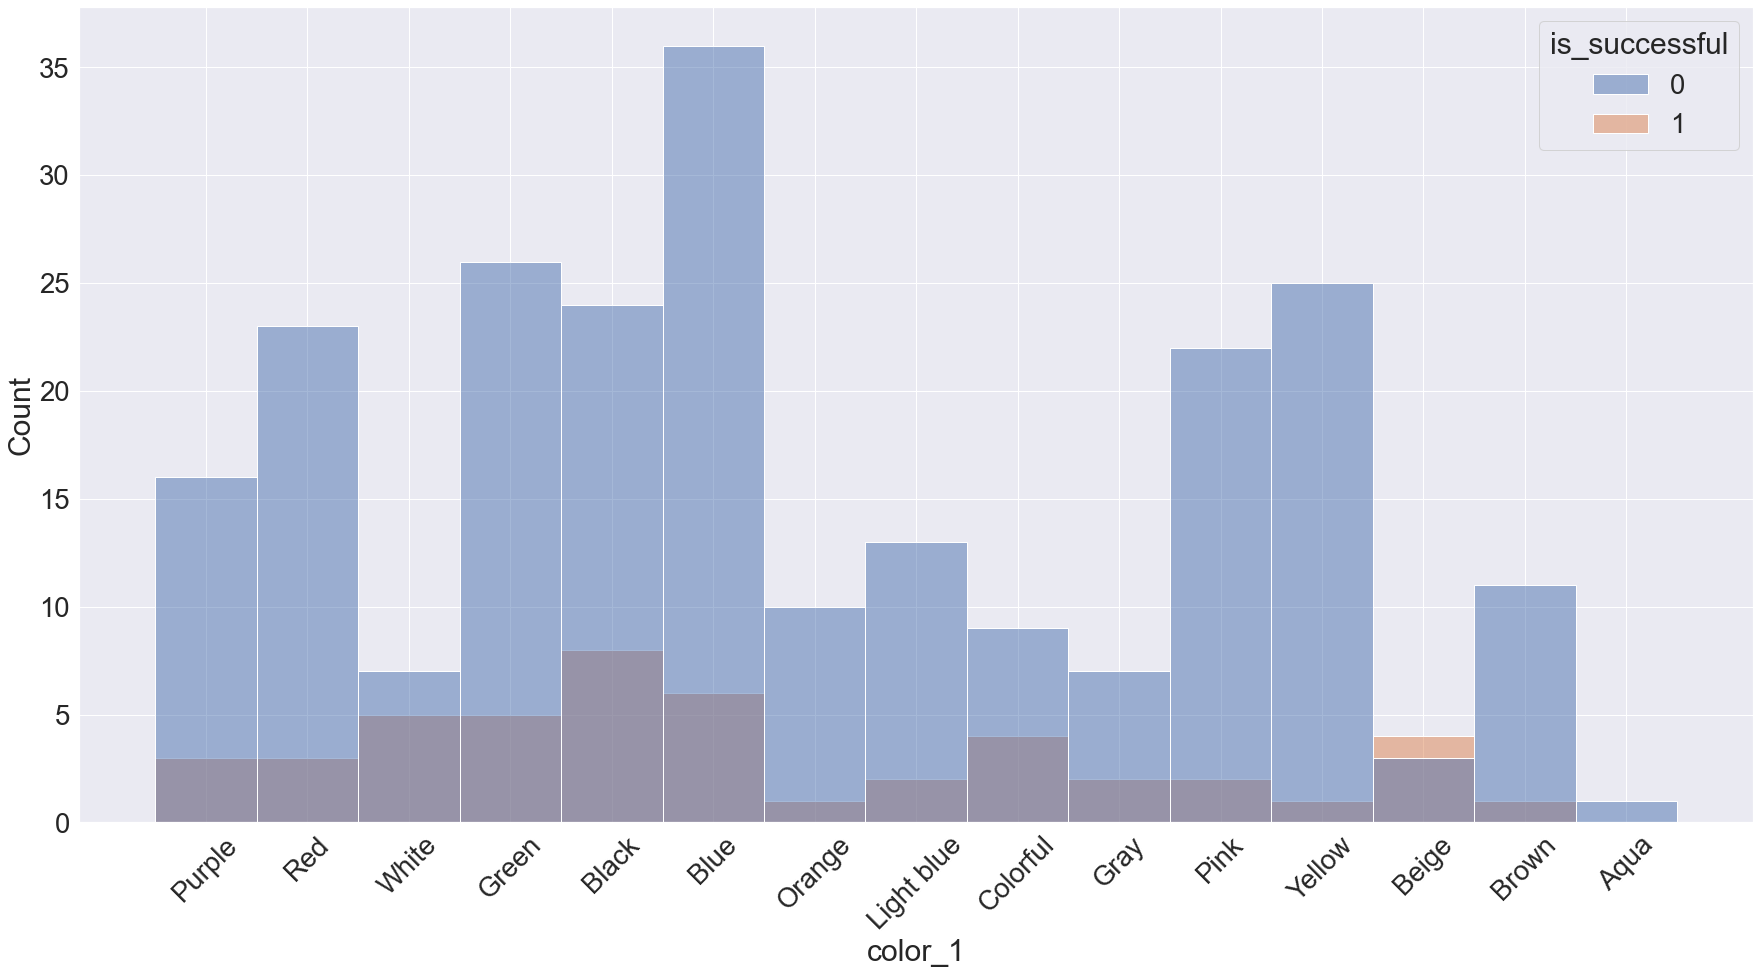

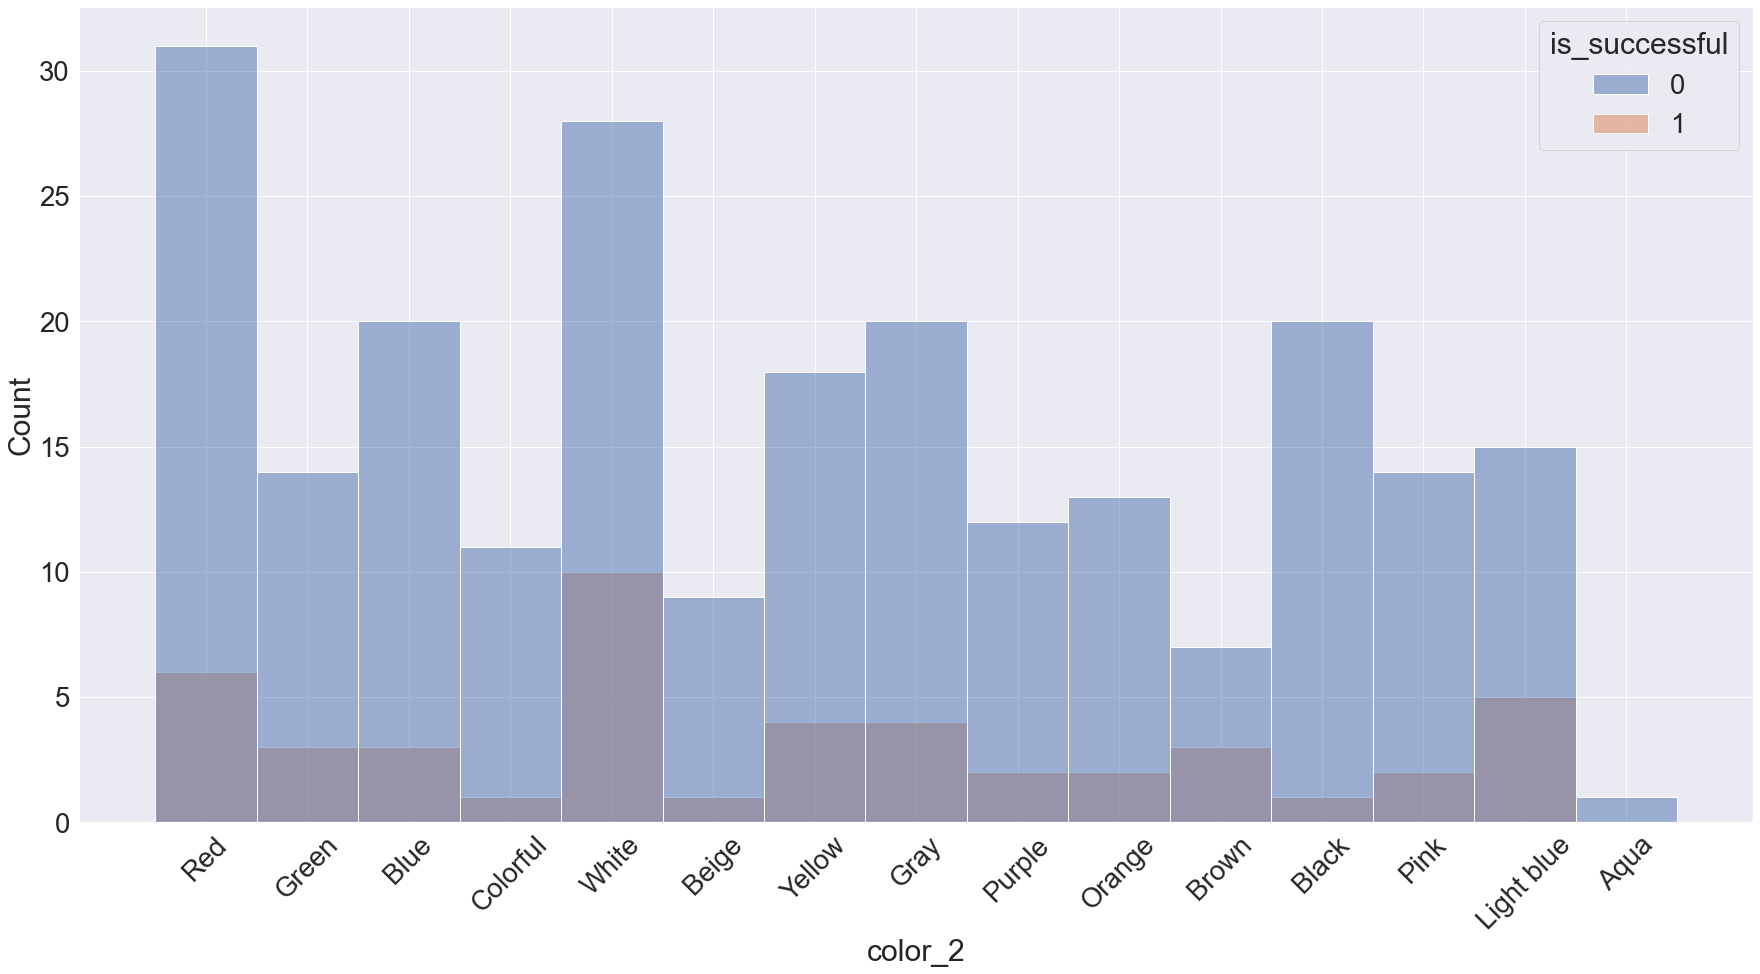

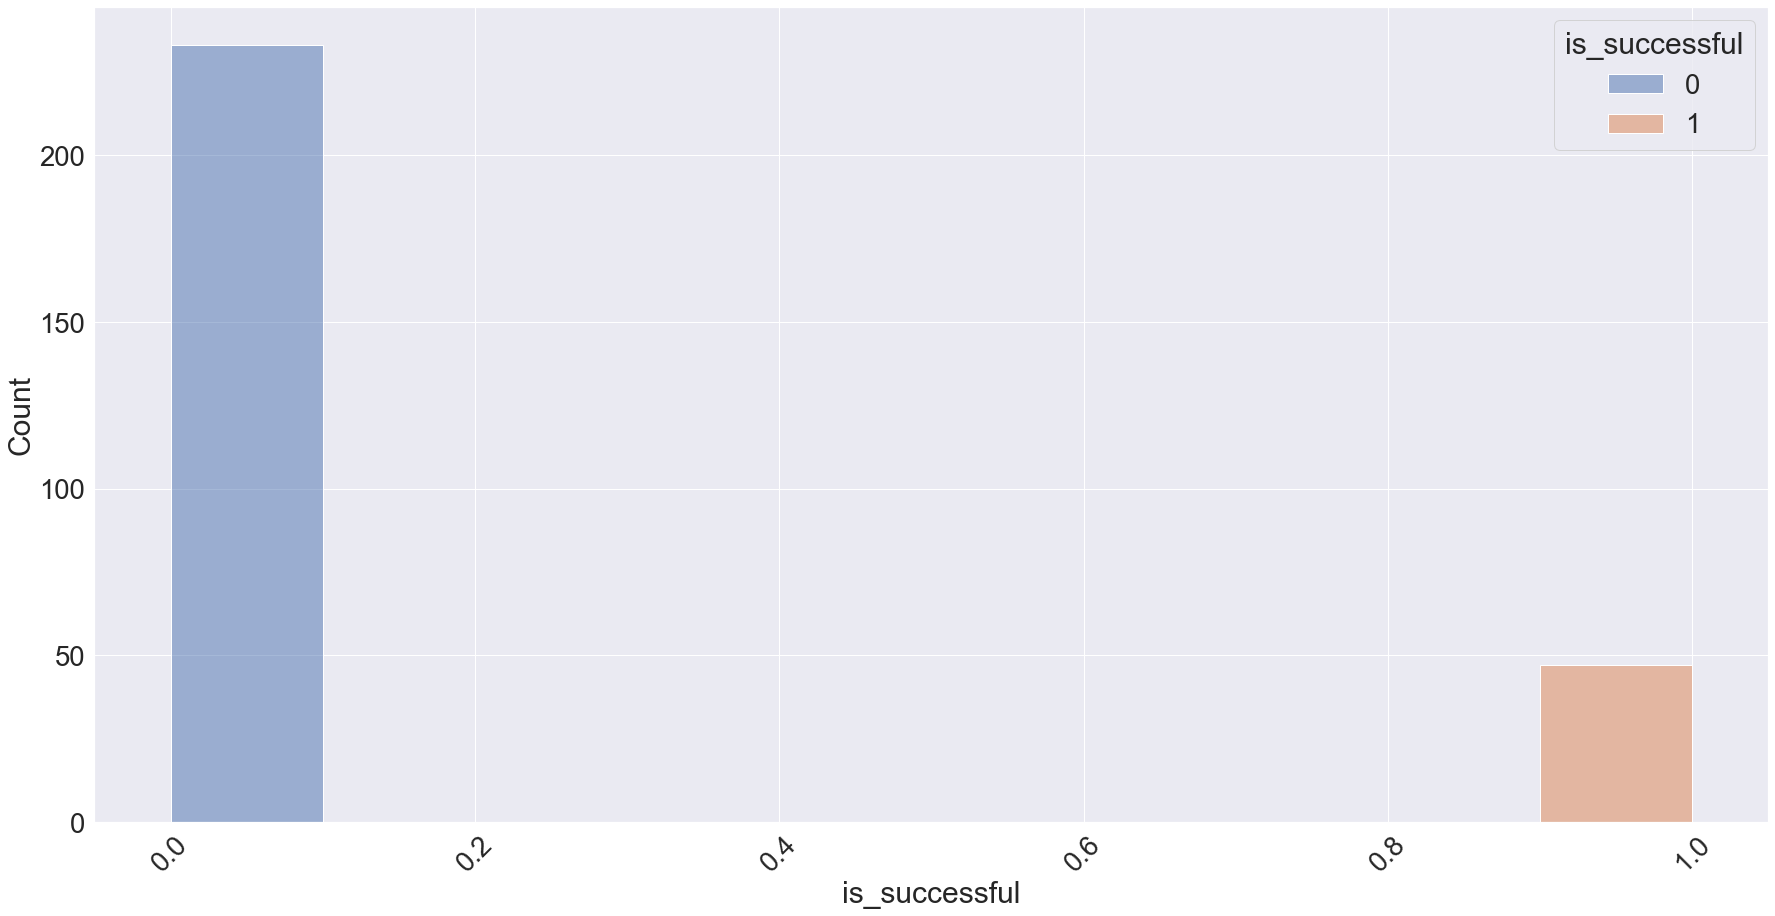

In [58]:
column_hist_plots()

<AxesSubplot:xlabel='species', ylabel='position'>

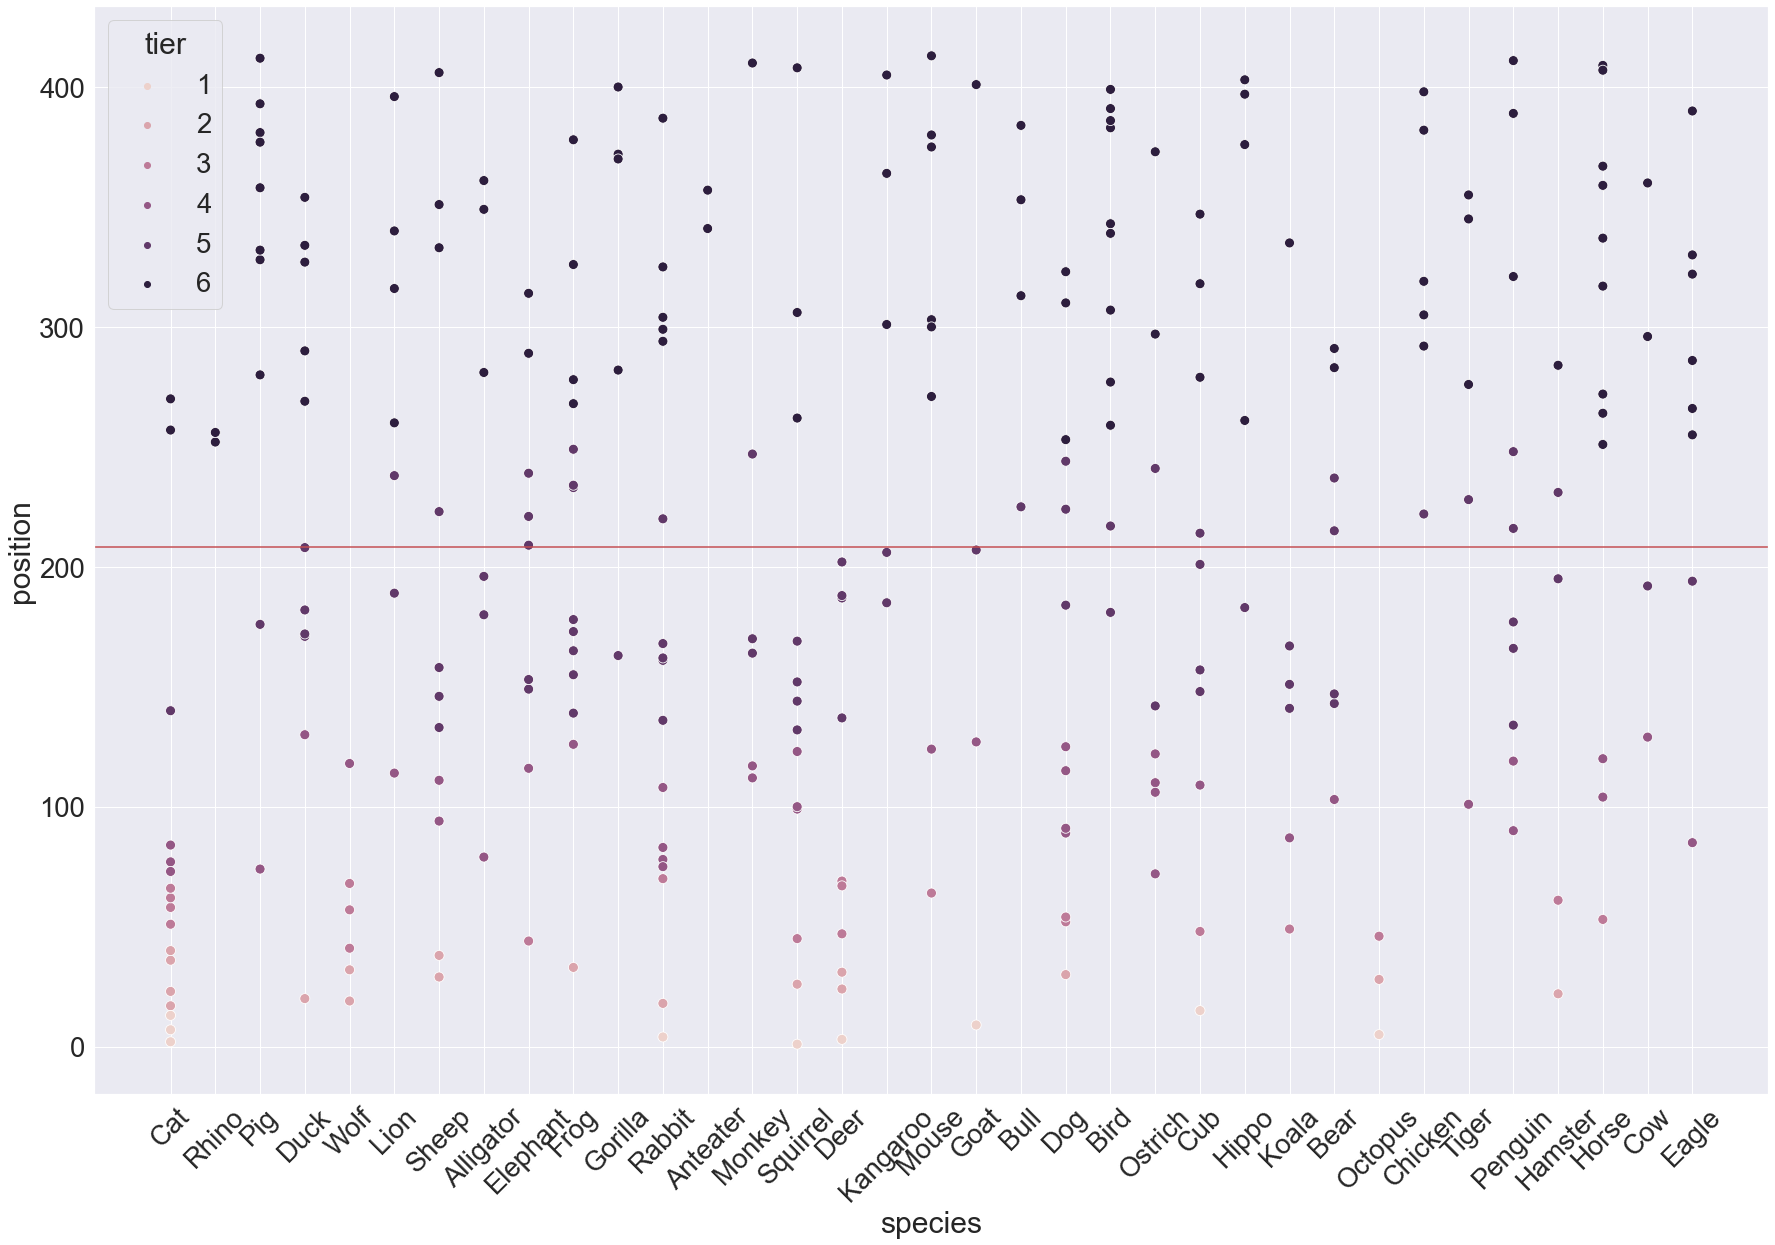

In [59]:
plt.figure(figsize=(30,20))
plt.axhline(overall_mean, color='r')
sns.set(font_scale=2.5)
plt.xticks(rotation=45)
sns.scatterplot(x="species", y='position', hue='tier', s=100, data=train)

In [60]:
df.head(1)

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1


In [61]:
# drop every column except is_successful

In [62]:
train.shape, validate.shape, test.shape

((280, 12), (71, 12), (62, 12))

In [63]:
df.species.nunique()

35

In [64]:
df.personality.nunique()

8

In [65]:
df.style_1.nunique()

6

In [66]:
df.hobby.nunique()

6

In [67]:
df.gender.nunique()

2

In [68]:
35+8+6+6+2

57

In [69]:
train.shape

(280, 12)

In [70]:
57+12

69

In [71]:
train1 = train.copy()

In [72]:
def is_cat(df):
    if df.species.lower() == 'cat':
        return 1
    else:
        return 0

train1['is_cat'] = train1.apply(is_cat, axis = 1)

In [73]:
def is_rhino(df):
    if df.species.lower() == 'rhino':
        return 1
    else:
        return 0

train1['is_rhino'] = train1.apply(is_rhino, axis = 1)

In [74]:
df.hobby.unique()

array(['Music', 'Nature', 'Education', 'Fashion', 'Play', 'Fitness'],
      dtype=object)

In [75]:
train1.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,Red,1
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,Green,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,Blue,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,Colorful,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,White,1


In [76]:
train2 = train.copy()

In [77]:
train2.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,Red,1
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,Green,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,Blue,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,Colorful,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,White,1


In [78]:
train2 = wrangle.encode_species_vars(train2)

In [79]:
train2.head(15)

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,...,is_anteater,is_monkey,is_lion,is_cow,is_hippo,is_gorilla,is_kangaroo,is_bird,is_chicken,is_bull
Name,,,,,,,,,,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,...,0,0,0,0,0,0,0,0,0,0
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,...,0,0,0,0,0,0,0,0,0,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,...,0,0,0,0,0,0,0,0,0,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,...,0,0,0,0,0,0,0,0,0,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,...,0,0,0,0,0,0,0,0,0,0
Mott,238,5,Lion,Male,Jock,Fitness,K.K. Fusion,Active,Elegant,Blue,...,0,0,1,0,0,0,0,0,0,0
Wendy,133,5,Sheep,Female,Peppy,Fashion,Space K.K.,Cool,Gorgeous,Red,...,0,0,0,0,0,0,0,0,0,0
Drago,79,4,Alligator,Male,Lazy,Nature,Imperial K.K.,Elegant,Gorgeous,Orange,...,0,0,0,0,0,0,0,0,0,0
Big Top,289,6,Elephant,Male,Lazy,Play,Go K.K. Rider,Simple,Active,Green,...,0,0,0,0,0,0,0,0,0,0


In [80]:
train1.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,Red,1
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,Green,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,Blue,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,Colorful,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,White,1


# Modeling

In [81]:
train_test_vars = train.copy()
train_test_vars.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Kabuki,58,3,Cat,Male,Cranky,Music,K.K. Jongara,Simple,Simple,Purple,Red,1
Tank,252,6,Rhino,Male,Jock,Fitness,K.K. Lament,Active,Simple,Red,Green,0
Cobb,280,6,Pig,Male,Jock,Education,Pondering,Simple,Active,White,Blue,0
Freckles,290,6,Duck,Female,Peppy,Fashion,Marine Song 2001,Simple,Cute,Green,Colorful,0
Kyle,68,3,Wolf,Male,Smug,Music,K.K. Metal,Gorgeous,Cool,Black,White,1


In [82]:
train_test_vars = wrangle.encode_all_vars(df)

In [83]:
train_test_vars.T

Name,Marshal,Raymond,Shino,Sasha,Zucker,Stitches,Ankha,Judy,Sherb,Ione,...,Velma,Mathilda,Curlos,Peaches,Ricky,Clyde,Monty,Gwen,Curly,Rizzo
is_successful,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
is_female,0,0,1,0,0,0,1,1,0,1,...,1,1,0,1,0,0,0,1,0,0
is_music,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
is_nature,0,1,0,0,1,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
is_education,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,1,0,0,1
is_fashion,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
is_play,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
is_fitness,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
is_elegant,1,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
is_simple,0,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1


In [84]:
train_test_vars.columns.drop

<bound method Index.drop of Index(['is_successful', 'is_female', 'is_music', 'is_nature', 'is_education',
       'is_fashion', 'is_play', 'is_fitness', 'is_elegant', 'is_simple',
       'is_gorgeous', 'is_cute', 'is_cool', 'is_active', 'is_squirrel',
       'is_cat', 'is_deer', 'is_rabbit', 'is_octopus', 'is_cub', 'is_goat',
       'is_duck', 'is_wolf', 'is_rhino', 'is_hamster', 'is_dog', 'is_sheep',
       'is_frog', 'is_ostrich', 'is_penguin', 'is_horse', 'is_eagle',
       'is_elephant', 'is_koala', 'is_mouse', 'is_pig', 'is_alligator',
       'is_bear', 'is_tiger', 'is_anteater', 'is_monkey', 'is_lion', 'is_cow',
       'is_hippo', 'is_gorilla', 'is_kangaroo', 'is_bird', 'is_chicken',
       'is_bull', 'is_smug', 'is_peppy', 'is_lazy', 'is_snooty', 'is_normal',
       'is_jock', 'is_big_sister', 'is_cranky'],
      dtype='object')>

### create an add encoded function that adds the encoded values to the train, validate, test 

In [85]:
train = wrangle.encode_all_vars(train)
validate = wrangle.encode_all_vars(validate)
test = wrangle.encode_all_vars(test)

In [86]:
X_train = train.drop(columns=["is_successful"])
y_train = train.is_successful

X_validate = validate.drop(columns=["is_successful"])
y_validate = validate.is_successful

X_test = test.drop(columns=["is_successful"])
y_test = test.is_successful


In [87]:
for i in range(2, 21):
    tree = DecisionTreeClassifier(max_depth=i, random_state=17)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 2
                             0                    1             accuracy  \
precision                 0.88                 0.83                 0.88   
recall                    0.99                 0.32                 0.88   
f1-score                  0.93                 0.46                 0.88   
support                 233.00                47.00                 0.88   

                     macro avg         weighted avg  
precision                 0.86                 0.87  
recall                    0.65                 0.88  
f1-score                  0.70                 0.85  
support                 280.00               280.00  

Tree with max depth of 3
                             0                    1             accuracy  \
precision                 0.90                 0.78                 0.89   
recall                    0.97                 0.45                 0.89   
f1-score                  0.93                 0.57                 0.

In [120]:
tree = DecisionTreeClassifier(max_depth=4, random_state=17)
tree = tree.fit(X_train, y_train)
y_predictions = tree.predict(X_train)

report = classification_report(y_train, y_predictions, output_dict=True)
print(f"Tree with max depth of {i}")
print(pd.DataFrame(report))
print()

Tree with max depth of 2
                             0                    1             accuracy  \
precision                 0.91                 0.85                 0.90   
recall                    0.98                 0.49                 0.90   
f1-score                  0.94                 0.62                 0.90   
support                 233.00                47.00                 0.90   

                     macro avg         weighted avg  
precision                 0.88                 0.90  
recall                    0.74                 0.90  
f1-score                  0.78                 0.89  
support                 280.00               280.00  



In [121]:
tree = DecisionTreeClassifier(max_depth=4, random_state=17)
tree = tree.fit(X_validate, y_validate)
y_predictions = tree.predict(X_validate)

report = classification_report(y_validate, y_predictions, output_dict=True)
print(f"Tree with max depth of {12}")
print(pd.DataFrame(report))
print()

Tree with max depth of 12
                             0                    1             accuracy  \
precision                 0.94                 1.00                 0.94   
recall                    1.00                 0.60                 0.94   
f1-score                  0.97                 0.75                 0.94   
support                  61.00                10.00                 0.94   

                     macro avg         weighted avg  
precision                 0.97                 0.95  
recall                    0.80                 0.94  
f1-score                  0.86                 0.94  
support                  71.00                71.00  



In [91]:
from sklearn.metrics import recall_score

In [93]:
rf5 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=300,
                            max_depth=5, 
                            random_state=17)

In [94]:
rf5.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, min_samples_leaf=3, n_estimators=300,
                       random_state=17)

In [95]:
y_pred = rf5.predict(X_train)

In [96]:
print(rf5.feature_importances_)
print(X_train.columns)


[0.02008216 0.01269359 0.02183282 0.0251884  0.02295477 0.02045028
 0.03658093 0.00837846 0.03096749 0.0137514  0.03012434 0.01518641
 0.01014876 0.00746135 0.20623717 0.10103017 0.01019444 0.05169132
 0.00449364 0.00248523 0.00254221 0.11755489 0.         0.01511838
 0.0119625  0.00765021 0.00350679 0.0039367  0.00516419 0.00184169
 0.00226361 0.0053305  0.00422655 0.00245669 0.00466389 0.0006596
 0.00301959 0.00056815 0.         0.00095142 0.00208764 0.00022025
 0.00108669 0.00113202 0.00059211 0.00744643 0.00185595 0.00034167
 0.01946584 0.01809156 0.01000206 0.02404005 0.0378105  0.01335035
 0.00772759 0.00939856]
Index(['is_female', 'is_music', 'is_nature', 'is_education', 'is_fashion',
       'is_play', 'is_fitness', 'is_elegant', 'is_simple', 'is_gorgeous',
       'is_cute', 'is_cool', 'is_active', 'is_squirrel', 'is_cat', 'is_deer',
       'is_rabbit', 'is_octopus', 'is_cub', 'is_goat', 'is_duck', 'is_wolf',
       'is_rhino', 'is_hamster', 'is_dog', 'is_sheep', 'is_frog', 'is_

In [97]:
y_pred_proba = rf5.predict_proba(X_train)

In [98]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf5.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.83


In [99]:
rf10 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=17)


In [100]:
rf10.fit(X_train, y_train)
y_pred = rf10.predict(X_train)
print(rf10.feature_importances_)


[0.03110788 0.0177577  0.02281108 0.02958263 0.0224993  0.0222418
 0.02562799 0.01267138 0.03087169 0.0102601  0.03163793 0.01323503
 0.01285206 0.00825092 0.21518661 0.10006275 0.01191973 0.0463495
 0.00458852 0.00130281 0.00542324 0.09084527 0.         0.00861365
 0.01775509 0.01191986 0.00266002 0.0035637  0.00454507 0.00258596
 0.00202461 0.00330402 0.00186775 0.00263991 0.00273745 0.00039772
 0.0022448  0.00086081 0.         0.00040191 0.00078942 0.00047734
 0.00060075 0.00093387 0.00093863 0.00474188 0.00103895 0.00082107
 0.02430043 0.02179024 0.01447835 0.02790186 0.03231382 0.01343299
 0.00638335 0.01384879]


In [101]:
y_pred_proba = rf10.predict_proba(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf10.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.85


In [102]:
from sklearn.metrics import recall_score

In [103]:
recall = recall_score(act,mod,pos_label=pos,zero_division=0)

NameError: name 'act' is not defined

In [104]:
    y_predictions = rf10.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {10}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 10
                             0                    1             accuracy  \
precision                 0.85                 0.86                 0.85   
recall                    1.00                 0.13                 0.85   
f1-score                  0.92                 0.22                 0.85   
support                 233.00                47.00                 0.85   

                     macro avg         weighted avg  
precision                 0.85                 0.85  
recall                    0.56                 0.85  
f1-score                  0.57                 0.80  
support                 280.00               280.00  



In [105]:
    y_predictions = rf5.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {5}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 5
                             0                    1             accuracy  \
precision                 0.83                 0.00                 0.83   
recall                    1.00                 0.00                 0.83   
f1-score                  0.91                 0.00                 0.83   
support                 233.00                47.00                 0.83   

                     macro avg         weighted avg  
precision                 0.42                 0.69  
recall                    0.50                 0.83  
f1-score                  0.45                 0.76  
support                 280.00               280.00  



In [106]:
rf15 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=15, 
                            random_state=17)

In [107]:
rf15.fit(X_train, y_train)
y_pred = rf15.predict(X_train)
print(rf15.feature_importances_)


[0.0358691  0.01492728 0.02423825 0.03198739 0.02513856 0.02458077
 0.02358652 0.01075896 0.03417123 0.01014659 0.03244171 0.01357998
 0.01039615 0.00834628 0.21540224 0.09792078 0.01450367 0.04244434
 0.00595364 0.0012685  0.00362054 0.09251153 0.         0.00817532
 0.01719421 0.01189454 0.00331021 0.00287393 0.00371244 0.00346753
 0.00182378 0.00346453 0.00170309 0.00321418 0.00314904 0.00039475
 0.00187661 0.00072393 0.         0.00046875 0.00084756 0.00034736
 0.00054741 0.00066076 0.00069844 0.00427378 0.00145422 0.00059977
 0.02324058 0.02162575 0.01453473 0.02303794 0.03305998 0.01525157
 0.00823658 0.01034272]


In [108]:
y_pred_proba = rf15.predict_proba(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf15.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.85


In [109]:
    y_predictions = rf15.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {15}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 15
                             0                    1             accuracy  \
precision                 0.85                 0.88                 0.85   
recall                    1.00                 0.15                 0.85   
f1-score                  0.92                 0.25                 0.85   
support                 233.00                47.00                 0.85   

                     macro avg         weighted avg  
precision                 0.86                 0.86  
recall                    0.57                 0.85  
f1-score                  0.59                 0.81  
support                 280.00               280.00  

